# Time series and Forecasting - Final Project

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_components
import re
from posixpath import defpath
import math
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

## Part 1 - Data selection, Visualization and Introduction (EDA)

In [49]:
rainfall = pd.read_csv('rainfall.csv')
rainfall.dropna(inplace = True)
rng = pd.date_range('01-01-2016', periods = len(rainfall), freq = 'D')
# index without time
rainfall.set_index(rng, inplace = True)

In [50]:
rainfall.shape

(1781, 10)

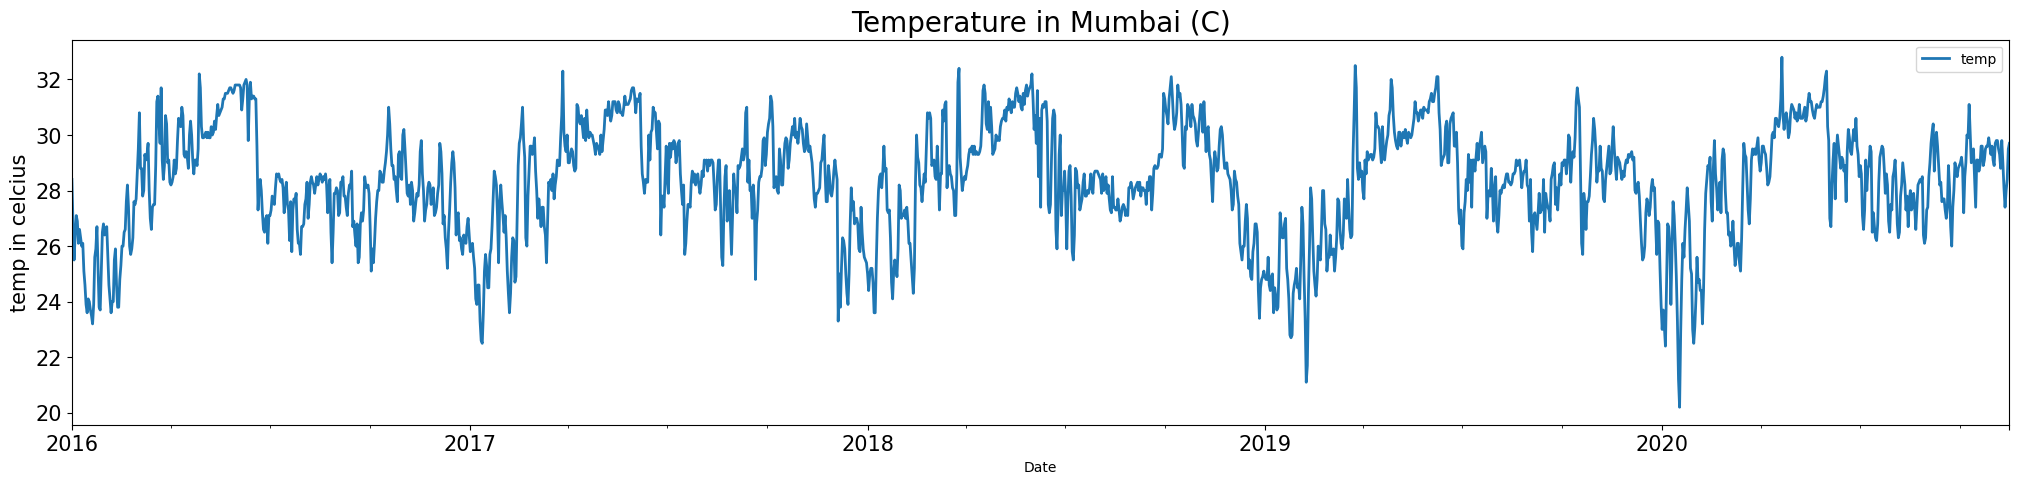

In [51]:
temp = rainfall[['temp']]
temp.plot(figsize=(25, 5), linewidth = 2, fontsize = 15)
plt.title('Temperature in Mumbai (C)', fontsize = 20)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('temp in celcius', fontsize = 15)
plt.show()

We'll aggregate the data over weeks so we training the different forecasting models (with apparent yearly seasonality) becomes feasible

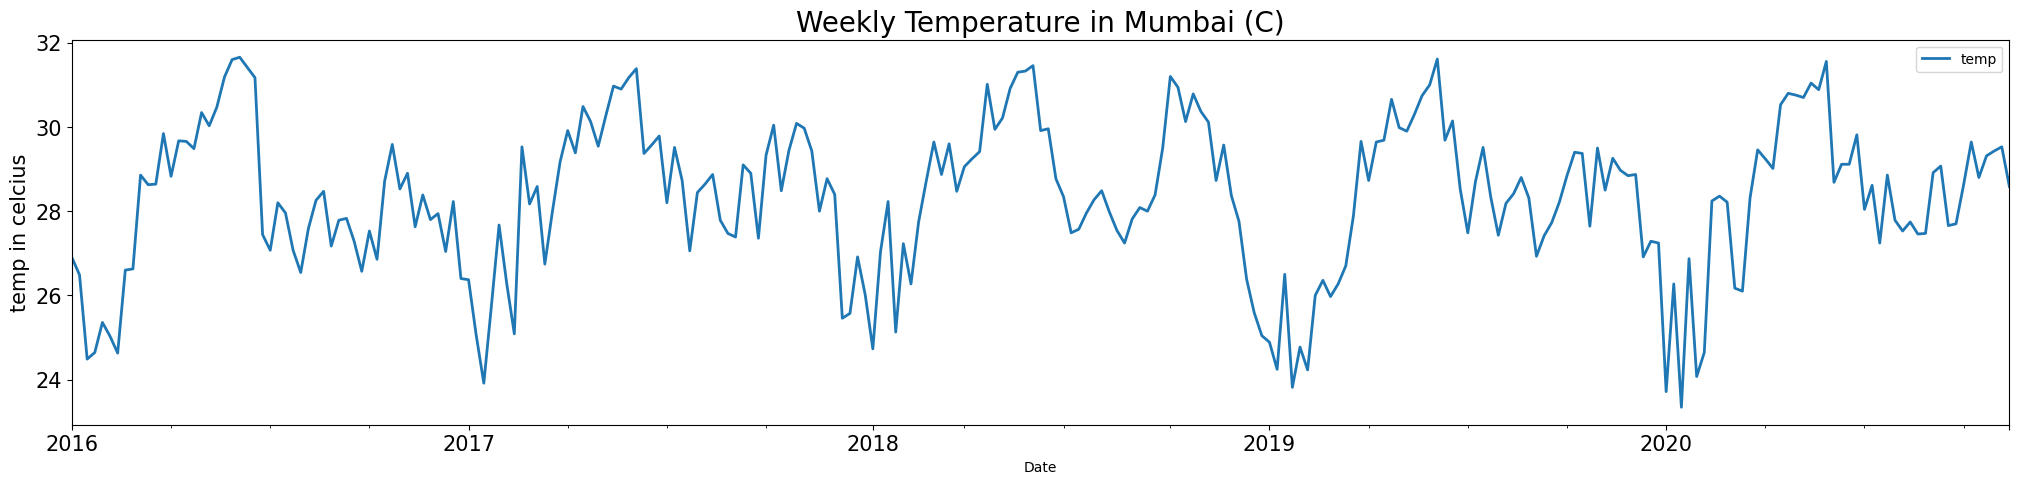

In [52]:
# mean over each week - create new df, temp_weekly
temp_weekly = temp.resample('W').mean()
temp_weekly.index =pd.to_datetime(temp_weekly.index)
temp_weekly.dropna(inplace=True)
temp_weekly.plot(figsize=(25, 5), linewidth=2, fontsize=15)
plt.title('Weekly Temperature in Mumbai (C)', fontsize = 20)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('temp in celcius', fontsize = 15)
plt.show()

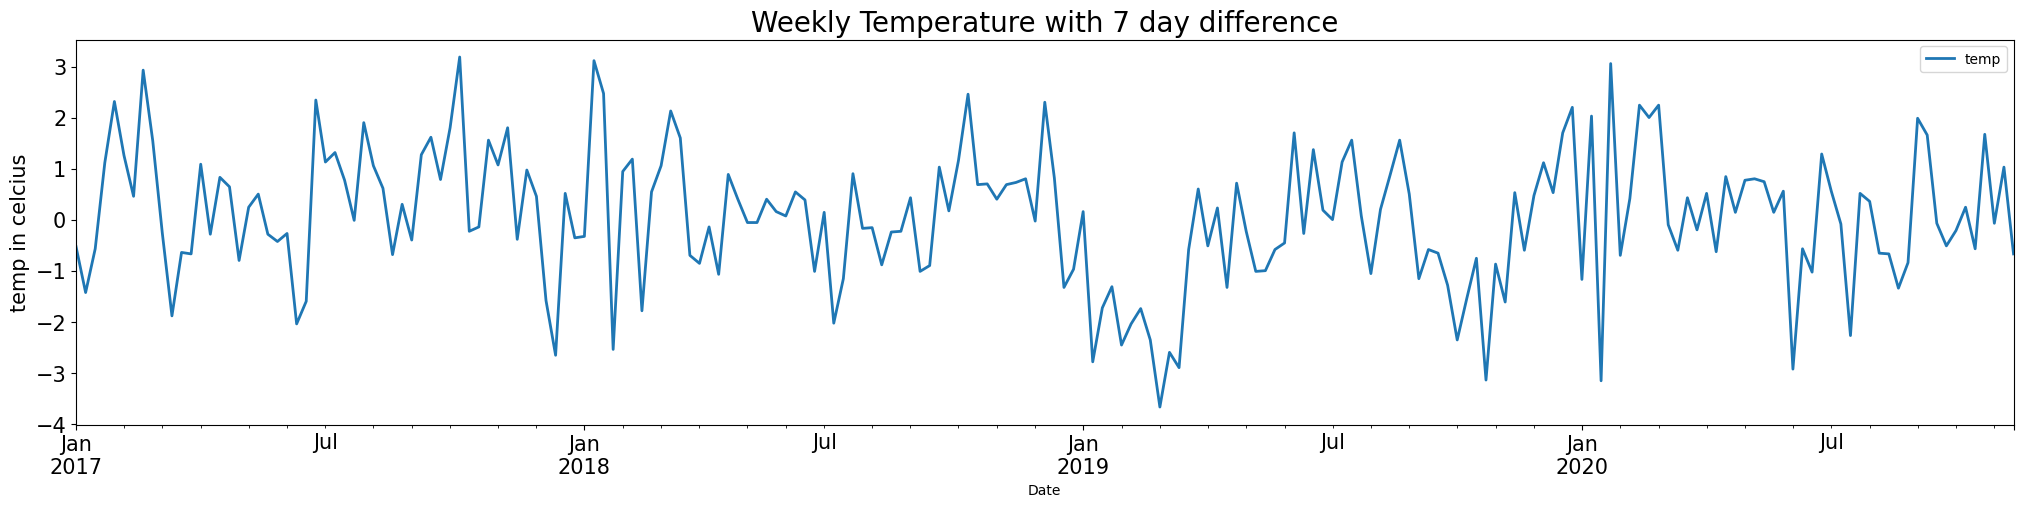

In [53]:
temp_diff = temp_weekly.diff(periods=52)
temp_diff = temp_diff.dropna()
temp_diff.plot(figsize=(25, 5), linewidth=2, fontsize=15)
plt.title('Weekly Temperature with 7 day difference', fontsize=20)
plt.xlabel('Date', fontsize=10)
plt.ylabel('temp in celcius', fontsize=15)
plt.show()

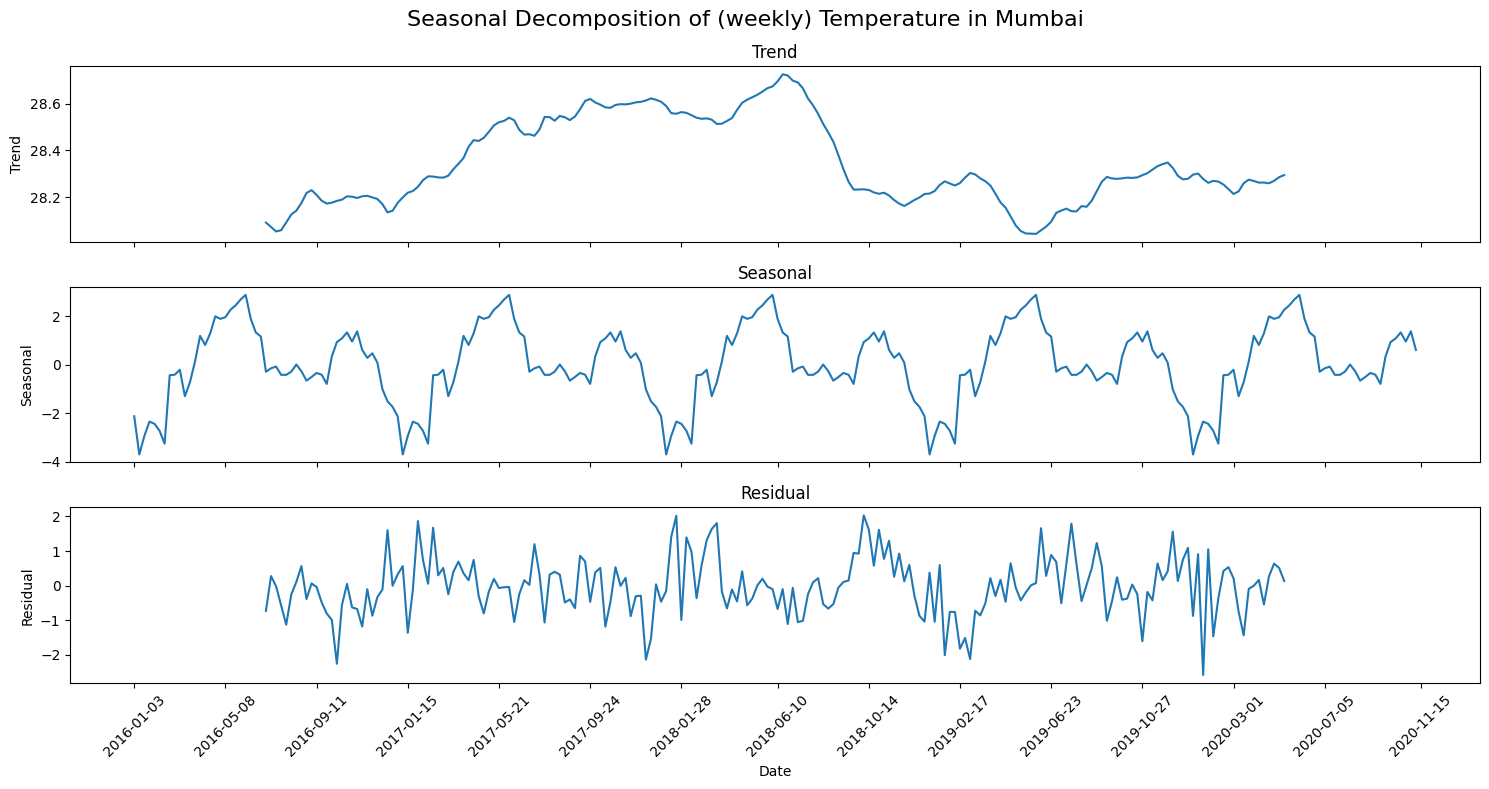

In [54]:
len_temp_weekly = len(temp_weekly)
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
SES = seasonal_decompose(temp_weekly['temp'].head(len_temp_weekly - 1), period=52, model='additive')
axs[0].plot(temp_weekly.index[:len_temp_weekly - 1], SES.trend)
axs[1].plot(temp_weekly.index[:len_temp_weekly - 1], SES.seasonal)
axs[2].plot(temp_weekly.index[:len_temp_weekly - 1], SES.resid)
fig.suptitle('Seasonal Decomposition of (weekly) Temperature in Mumbai', fontsize=16)
axs[0].set_title('Trend')
axs[0].set_ylabel('Trend')
axs[1].set_title('Seasonal')
axs[1].set_ylabel('Seasonal')
axs[2].set_title('Residual')
axs[2].set_ylabel('Residual')
axs[2].set_xlabel('Date')
xticks_indices = np.linspace(0, len_temp_weekly - 1, 15, dtype=int)
axs[2].set_xticks(temp_weekly.index[xticks_indices])
axs[2].set_xticklabels([dt.strftime('%Y-%m-%d') for dt in temp_weekly.index[xticks_indices]], rotation=45)
plt.tight_layout()
plt.show()

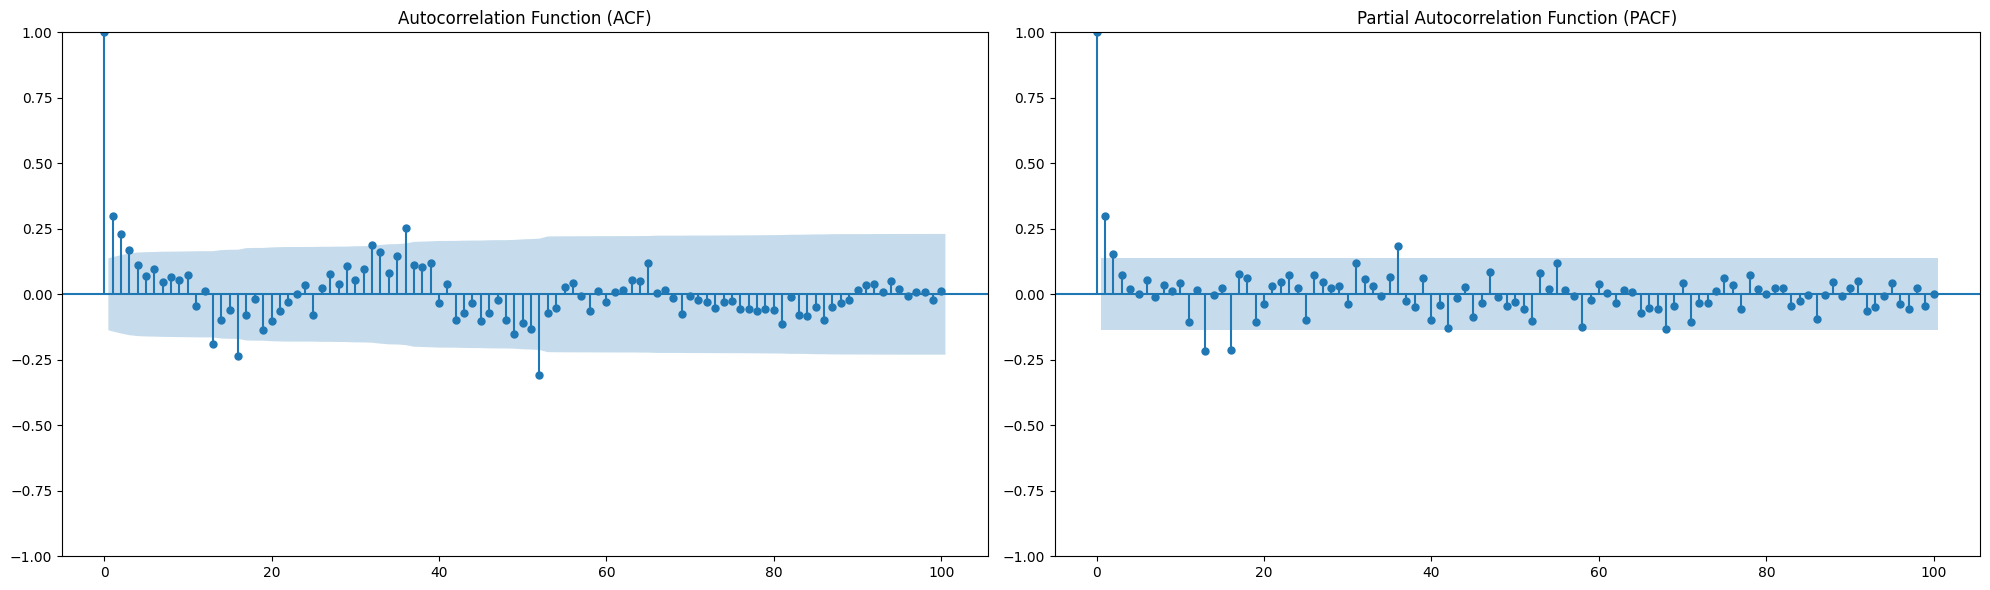

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
tsaplots.plot_acf(temp_diff, lags=100, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

tsaplots.plot_pacf(temp_diff, lags=100, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Part 2 - Model Fitting


Firstly we'll split our dataset into train and test sets.

The train set will be used to train the relevant models and the test set will be used to auxiliate in calculating how accurate the models are.

In [56]:
length_train = math.floor(0.7 * len(temp_weekly))

train_df = temp_weekly[:length_train]
test_df = temp_weekly[length_train:]

In [10]:
print(f'Length of train set: {len(train_df)}')
print(f'Length of test set: {len(test_df)}')
print(f'Total length of dataset : {len(train_df) + len(test_df)}')

Length of train set: 178
Length of test set: 77
Total length of dataset : 255


When analyzing the results, we'll access how the size of the dataset may have affected the values and how accurate we were.

##SARIMA


From the first graph:

  - The first components of the ACF are relevant so we will test $q=1, q=2$ for a Moving Average model.

  - The ACF has a sinusoid behaviour and peaks on weeks 16, 36 and 52. This will lead us to $Q=1$

From the second graph:

  - We'll assume that the model is either AR(1) or AR(2) seeing that the 2 first PACFs are relevantly different than 0.

  $p = 1$
  
  Given the peaks at weeks 16 and 36 so $P = 0 \space or \space P=1$, even if they're not too noticable we'll check.

  We'll test $d=0, d=1$

We have turned our time series into a stationary one to be able to conclude concrete by differenciating, so $D=1$

$$SARIMA(p, d, q)(P, D, Q)_{S}$$

$S$ is of course 52 given that that is the seasonality - yearly

In [57]:
sarima_params = [((1, 1, 1), (0, 1, 1, 52)),
                 ((1, 1, 1), (0, 1, 0, 52)),
                 ((1, 1, 1), (1, 1, 1, 52)),
                 ((1, 1, 1), (1, 1, 0, 52)),
                 ((1, 0, 1), (0, 1, 1, 52)),
                 ((1, 0, 1), (0, 1, 0, 52)),
                 ((1, 0, 1), (1, 1, 1, 52)),
                 ((1, 0, 1), (1, 1, 0, 52))]

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -192.427
Date:                            Wed, 26 Mar 2025   AIC                            392.854
Time:                                    09:40:43   BIC                            404.167
Sample:                                01-03-2016   HQIC                           397.450
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3666      0.097      3.767      0.000       0.176       0.557
ma.L1         -0.9236      0.047   

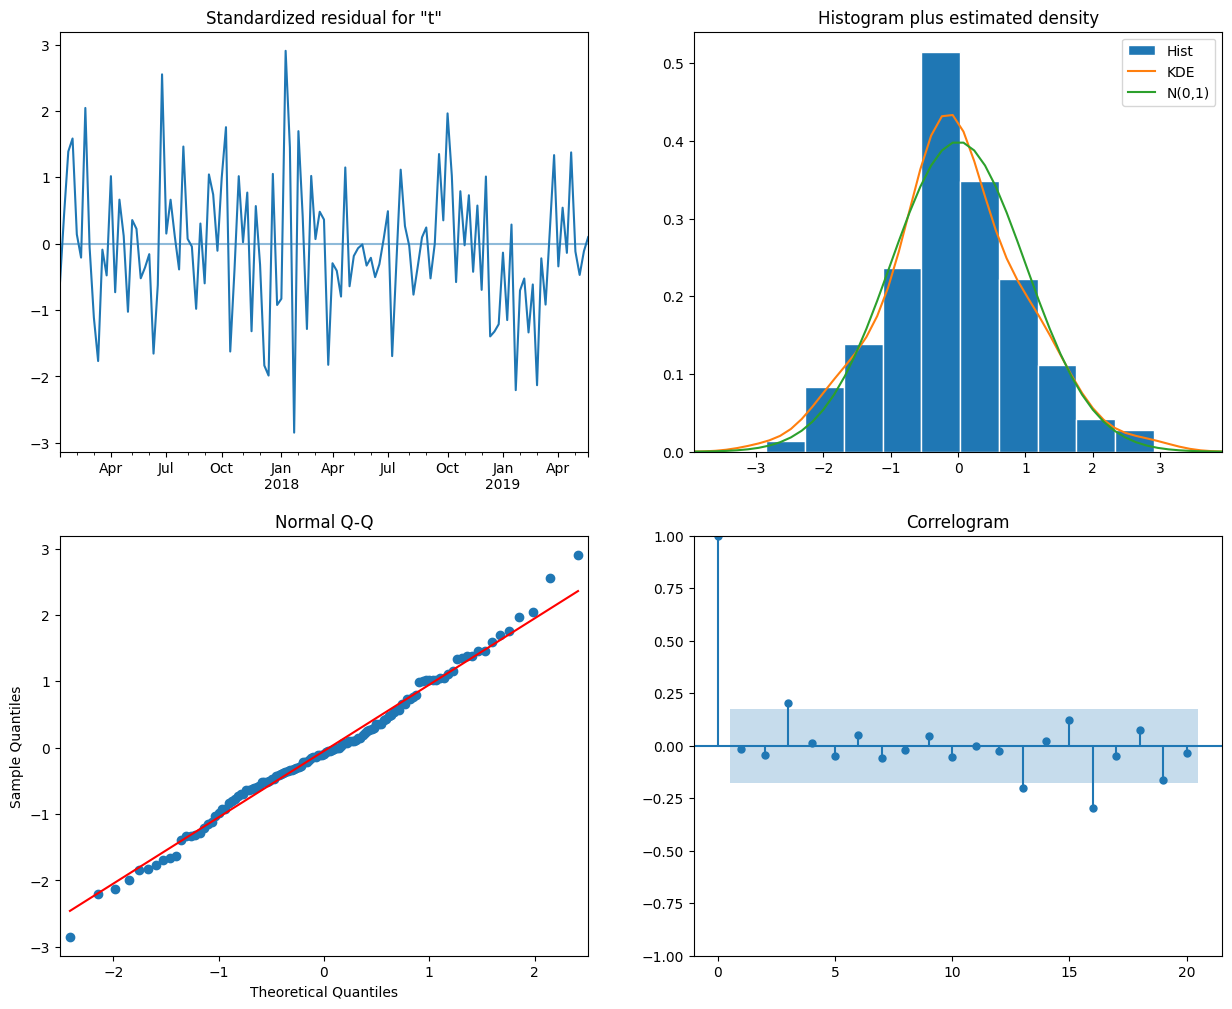

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -202.193
Date:                             Wed, 26 Mar 2025   AIC                            410.387
Time:                                     09:40:44   BIC                            418.872
Sample:                                 01-03-2016   HQIC                           413.834
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3567      0.102      3.489      0.000       0.156       0.557
ma.L1         -0.9482      

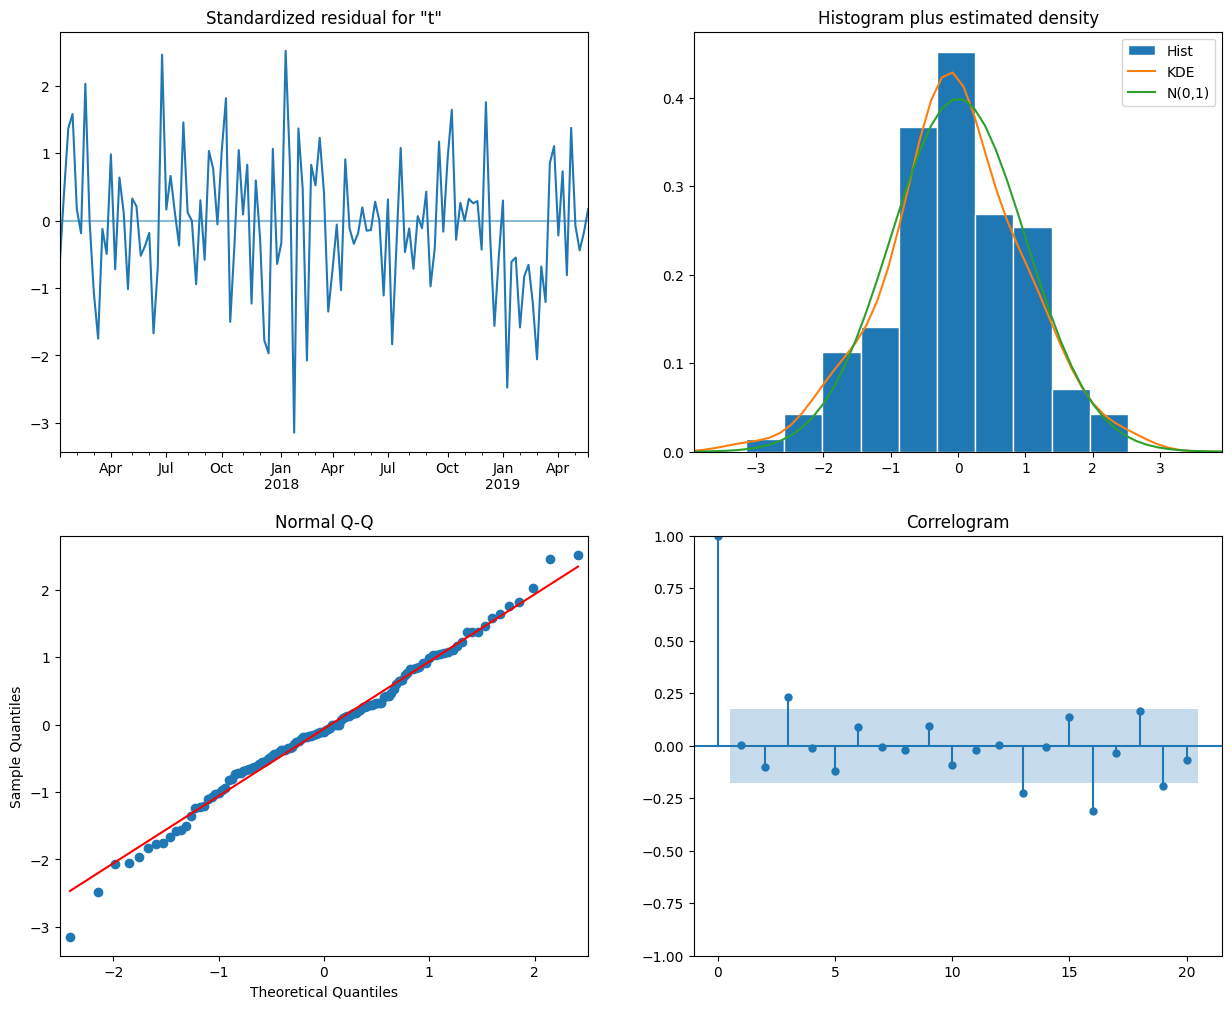

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -192.275
Date:                            Wed, 26 Mar 2025   AIC                            394.551
Time:                                    09:41:08   BIC                            408.692
Sample:                                01-03-2016   HQIC                           400.296
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3666      0.097      3.771      0.000       0.176       0.557
ma.L1         -0.9248      0.047   

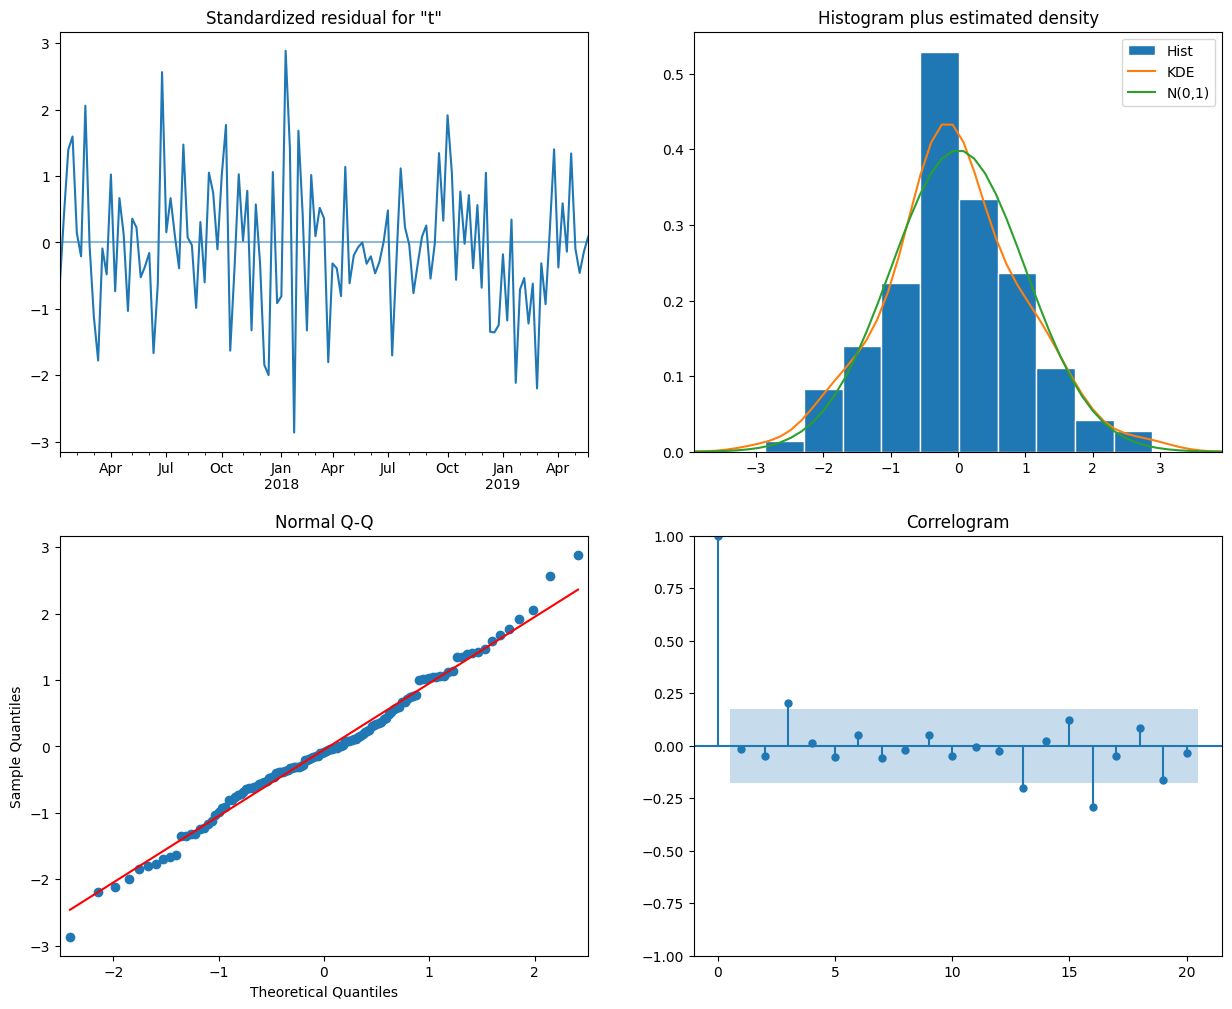

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                -193.460
Date:                             Wed, 26 Mar 2025   AIC                            394.920
Time:                                     09:41:16   BIC                            406.233
Sample:                                 01-03-2016   HQIC                           399.516
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3785      0.099      3.841      0.000       0.185       0.572
ma.L1         -0.9292      

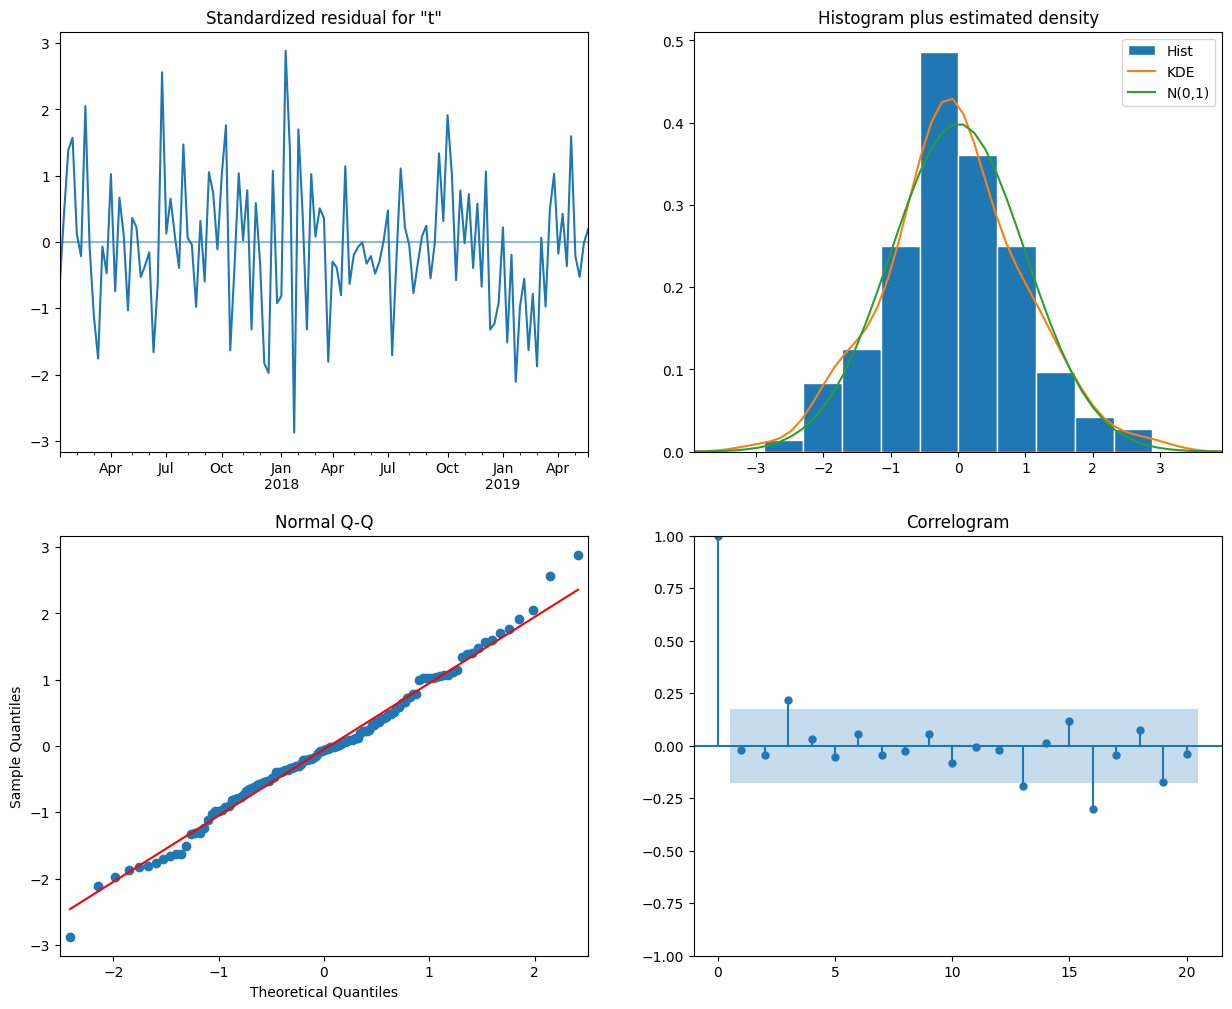

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -191.021
Date:                            Wed, 26 Mar 2025   AIC                            390.041
Time:                                    09:41:23   BIC                            401.386
Sample:                                01-03-2016   HQIC                           394.651
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7585      0.111      6.822      0.000       0.541       0.976
ma.L1         -0.4133      0.145   

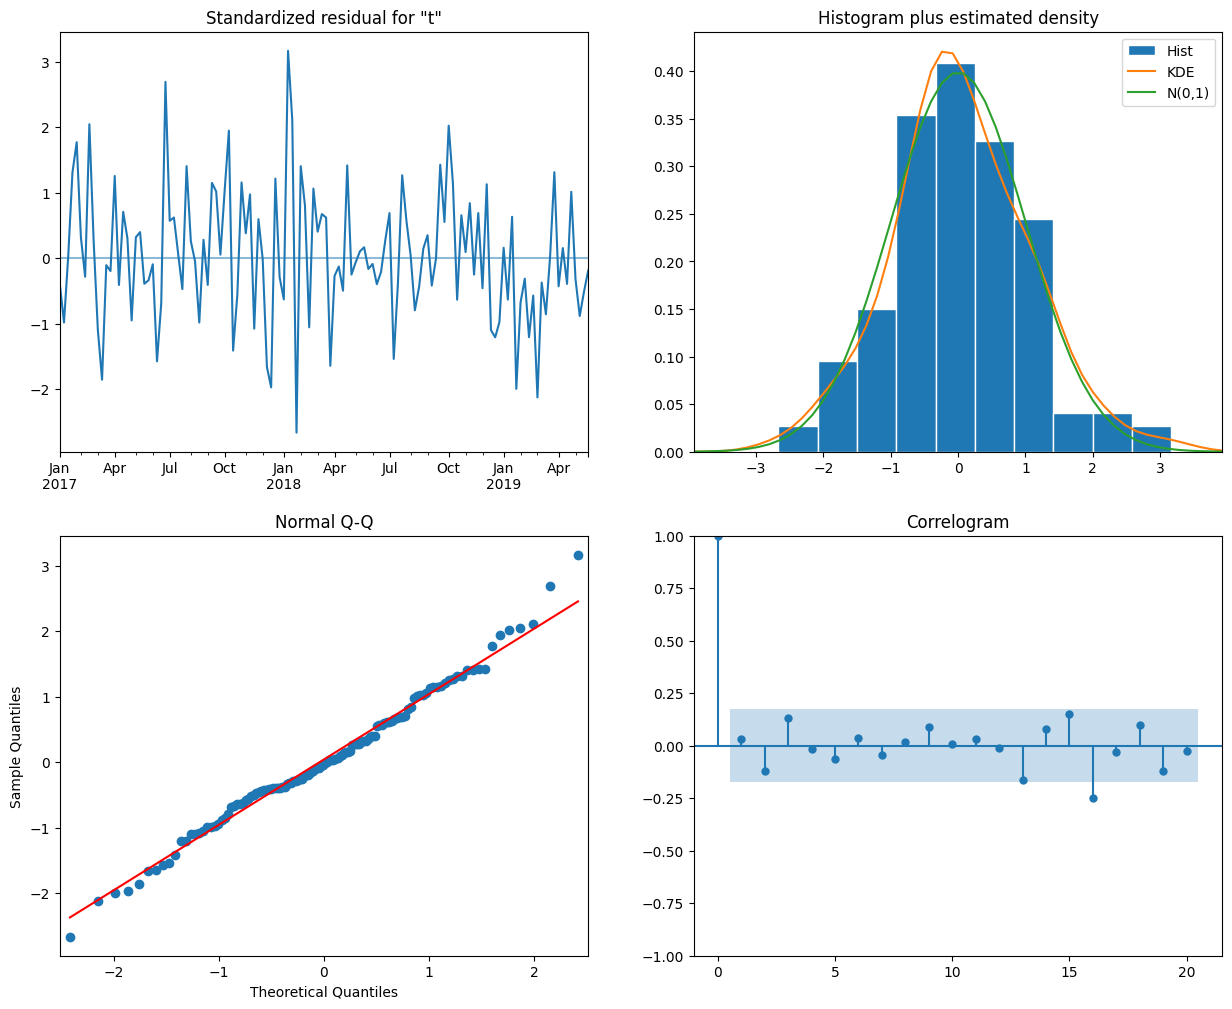

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 52)   Log Likelihood                -202.401
Date:                             Wed, 26 Mar 2025   AIC                            410.802
Time:                                     09:41:24   BIC                            419.311
Sample:                                 01-03-2016   HQIC                           414.259
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6727      0.144      4.674      0.000       0.391       0.955
ma.L1         -0.3240      

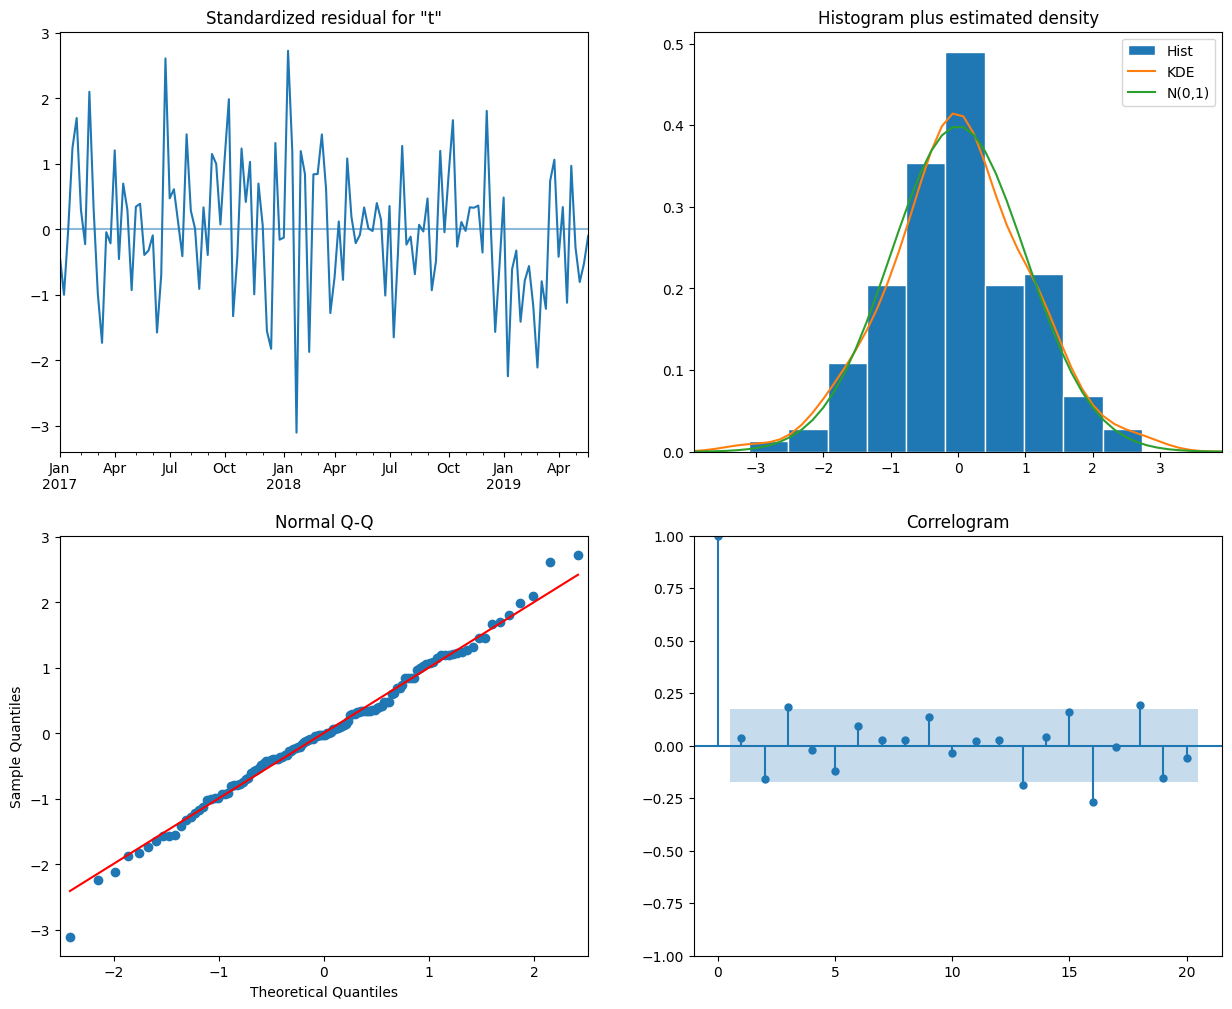

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -190.959
Date:                            Wed, 26 Mar 2025   AIC                            391.917
Time:                                    09:41:59   BIC                            406.099
Sample:                                01-03-2016   HQIC                           397.679
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7540      0.112      6.728      0.000       0.534       0.974
ma.L1         -0.4076      0.147   

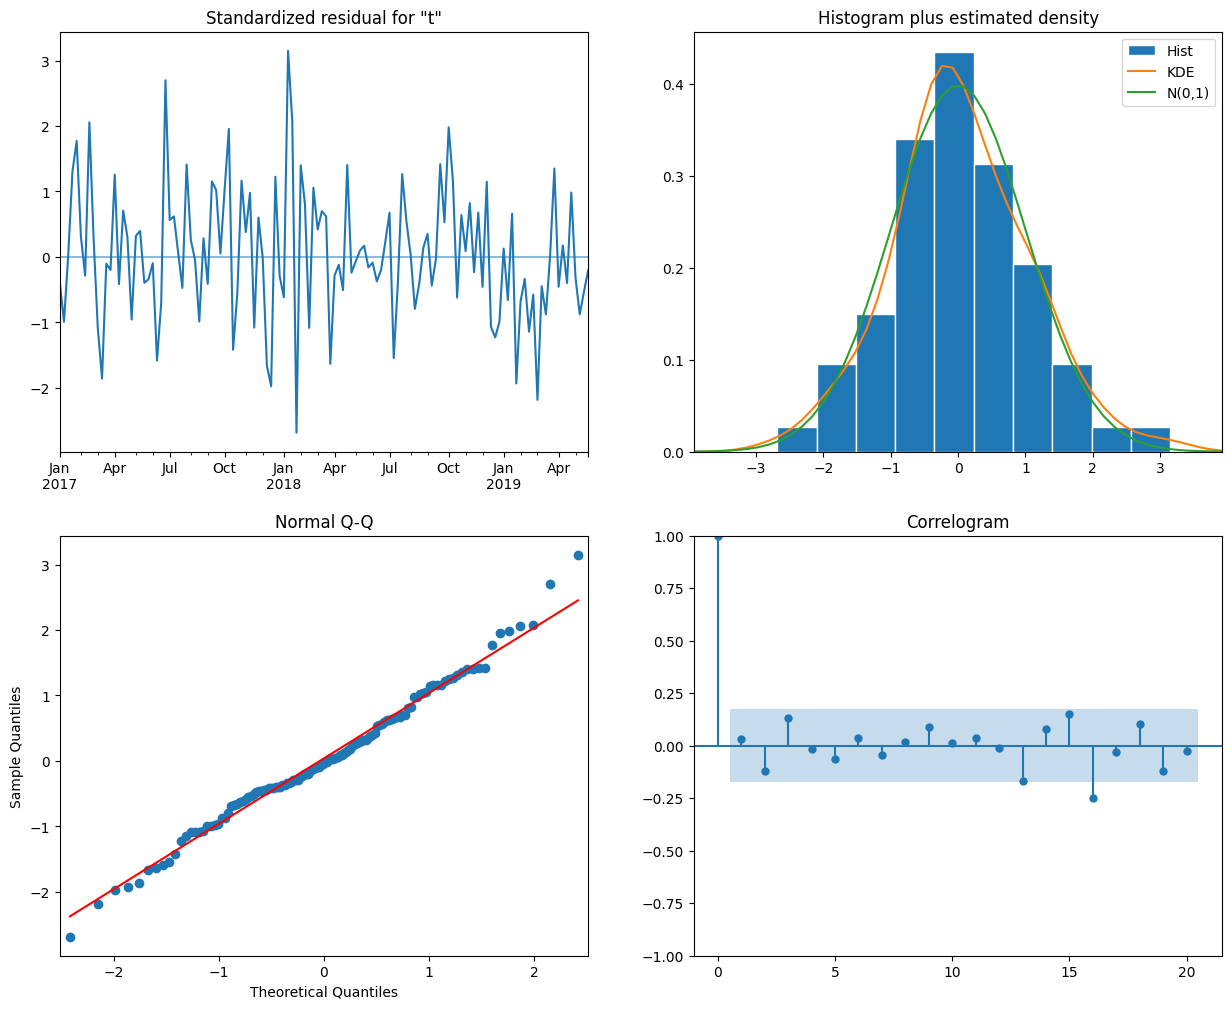

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood                -192.105
Date:                             Wed, 26 Mar 2025   AIC                            392.210
Time:                                     09:42:04   BIC                            403.555
Sample:                                 01-03-2016   HQIC                           396.819
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7750      0.106      7.304      0.000       0.567       0.983
ma.L1         -0.4237      

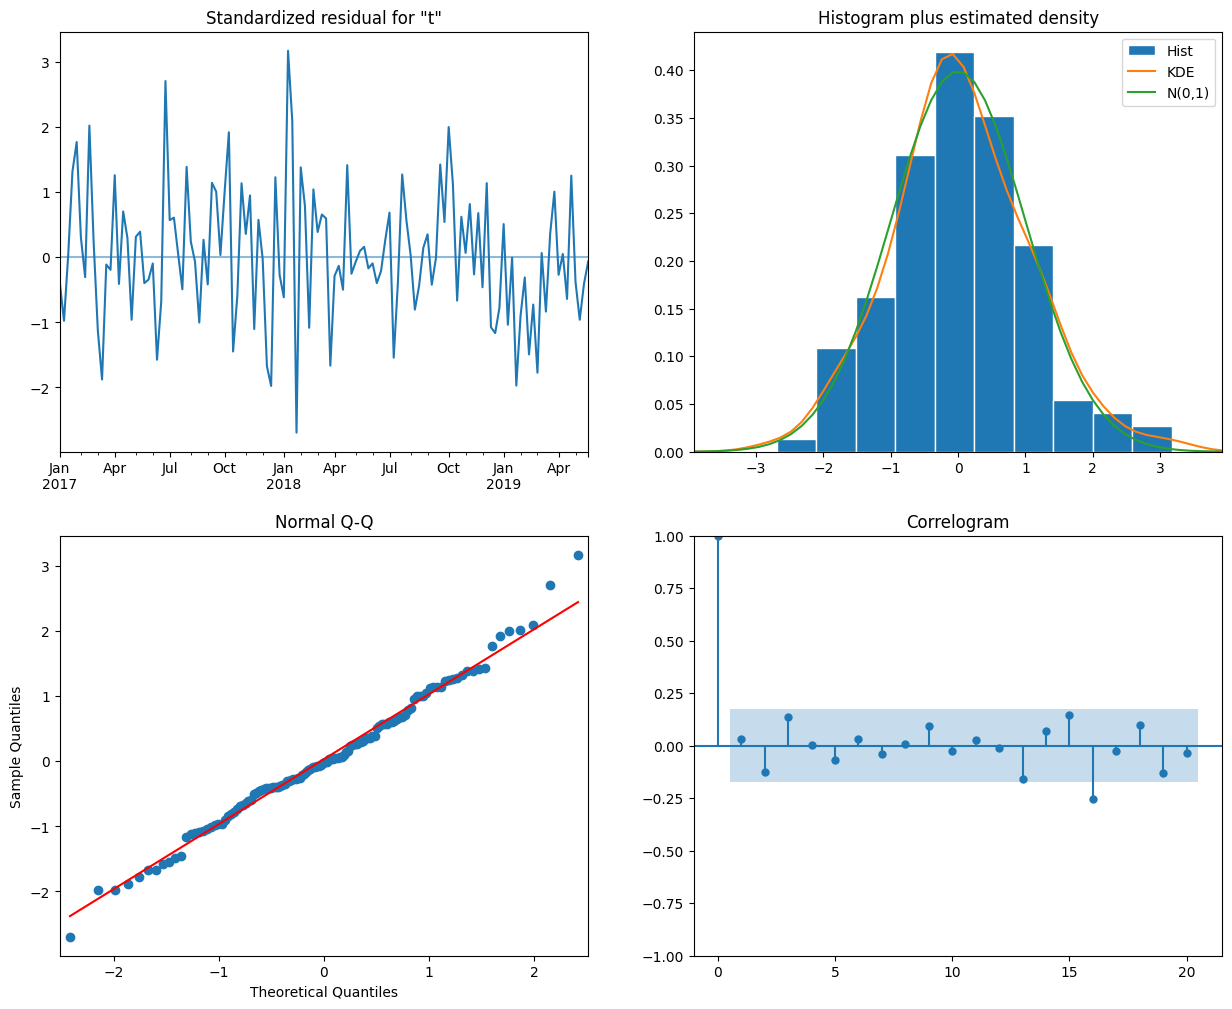

In [12]:
bics = {}
aics = {}
for param in sarima_params:
    model = SARIMAX(train_df, order=param[0], seasonal_order=param[1])
    model_fit = model.fit(disp=False)
    bics[f'BIC {param[0]} {param[1]}'] = model_fit.bic
    aics[f'AIC {param[0]} {param[1]}'] = model_fit.aic
    print(model_fit.summary())
    model_fit.plot_diagnostics(lags=20, figsize=(15, 12))
    plt.show()

In [13]:
# print a dictionary - with values ordered
bics_sorted = {k: v for k, v in sorted(bics.items(), key=lambda item: item[1])}
aics_sorted = {k: v for k, v in sorted(aics.items(), key=lambda item: item[1])}
#print
print('BICs:')
for k, v in bics_sorted.items():
    print(f'{k}: {v}')
print('AICs:')
for k, v in aics_sorted.items():
    print(f'{k}: {v}')


BICs:
BIC (1, 0, 1) (0, 1, 1, 52): 401.38647474955565
BIC (1, 0, 1) (1, 1, 0, 52): 403.5550776542369
BIC (1, 1, 1) (0, 1, 1, 52): 404.1668212274907
BIC (1, 0, 1) (1, 1, 1, 52): 406.09866307389933
BIC (1, 1, 1) (1, 1, 0, 52): 406.23343821087946
BIC (1, 1, 1) (1, 1, 1, 52): 408.69216366709765
BIC (1, 1, 1) (0, 1, 0, 52): 418.8716178548225
BIC (1, 0, 1) (0, 1, 0, 52): 419.3112893034711
AICs:
AIC (1, 0, 1) (0, 1, 1, 52): 390.0413471217497
AIC (1, 0, 1) (1, 1, 1, 52): 391.91725353914194
AIC (1, 0, 1) (1, 1, 0, 52): 392.209950026431
AIC (1, 1, 1) (0, 1, 1, 52): 392.8535662782815
AIC (1, 1, 1) (1, 1, 1, 52): 394.55059498058614
AIC (1, 1, 1) (1, 1, 0, 52): 394.9201832616703
AIC (1, 1, 1) (0, 1, 0, 52): 410.3866766429156
AIC (1, 0, 1) (0, 1, 0, 52): 410.80244358261666


The model that gets the best BIC is
$$Sarima(1, 0, 1)(0, 1, 1)_{52}$$
The model has an AR component but not seasonal AR, the model does not require integration but we did perform diferentiation once so $d=0, D=1$.
MA and seasonal MA take place.

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -191.021
Date:                            Wed, 26 Mar 2025   AIC                            390.041
Time:                                    09:42:13   BIC                            401.386
Sample:                                01-03-2016   HQIC                           394.651
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7585      0.111      6.822      0.000       0.541       0.976
ma.L1         -0.4133      0.145   

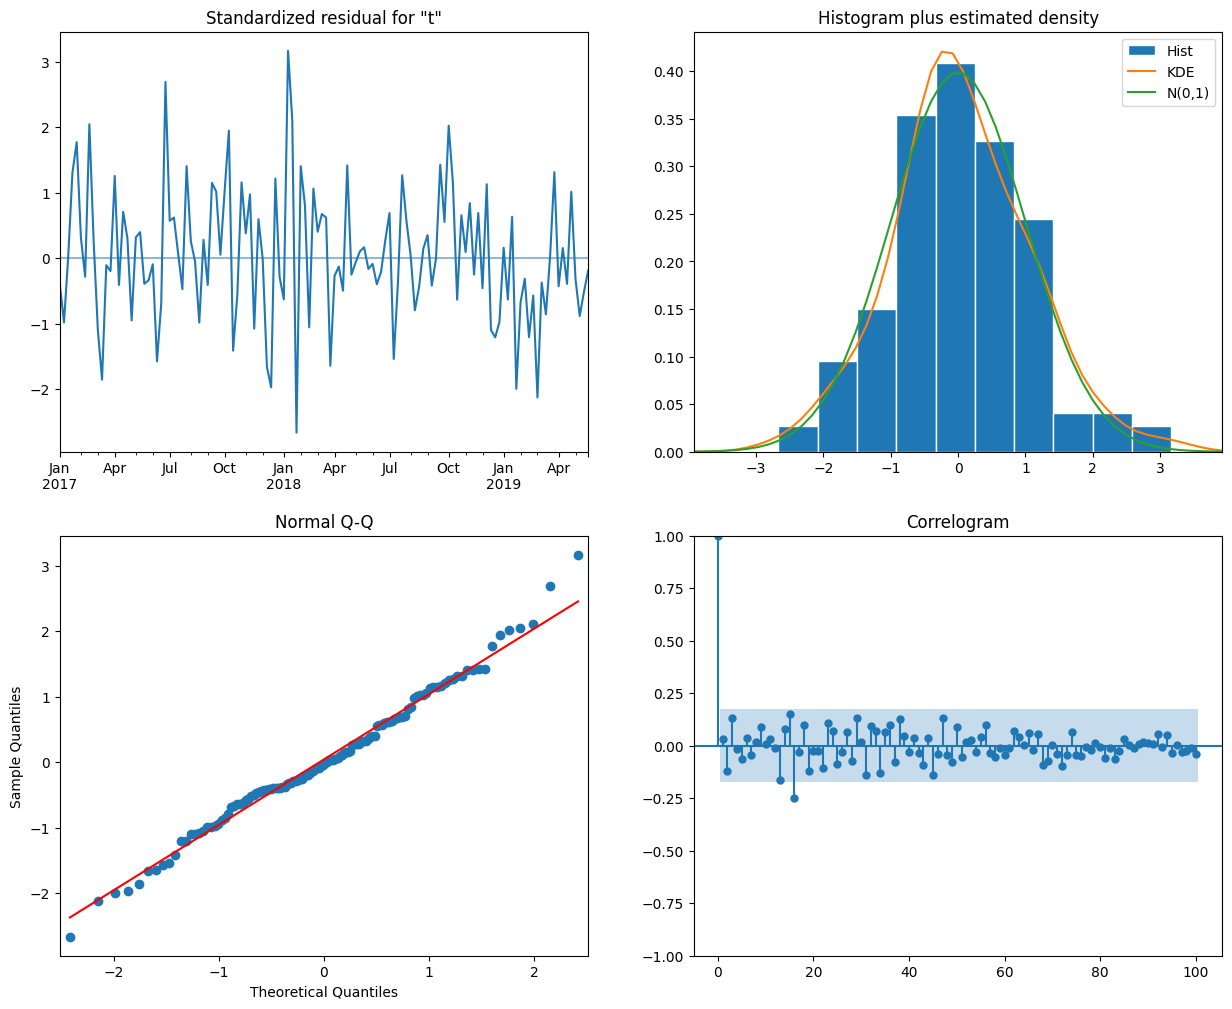

In [14]:
best_model = SARIMAX(train_df, order=(1,0,1), seasonal_order=(0,1,1,52))
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())
best_model_fit.plot_diagnostics(lags=100, figsize=(15, 12))
plt.show()

In [15]:
# Forecast 200 weeks ahead
forecast_steps = 200
next200w = best_model_fit.get_forecast(steps=forecast_steps)
next200w_ci = next200w.conf_int()

# Define forecast dates
futureDates = pd.date_range(start='2019-06-02', periods=forecast_steps, freq='W')
next200w_ci.index = futureDates

futureDF_forecast = pd.DataFrame(next200w.predicted_mean, index=futureDates)

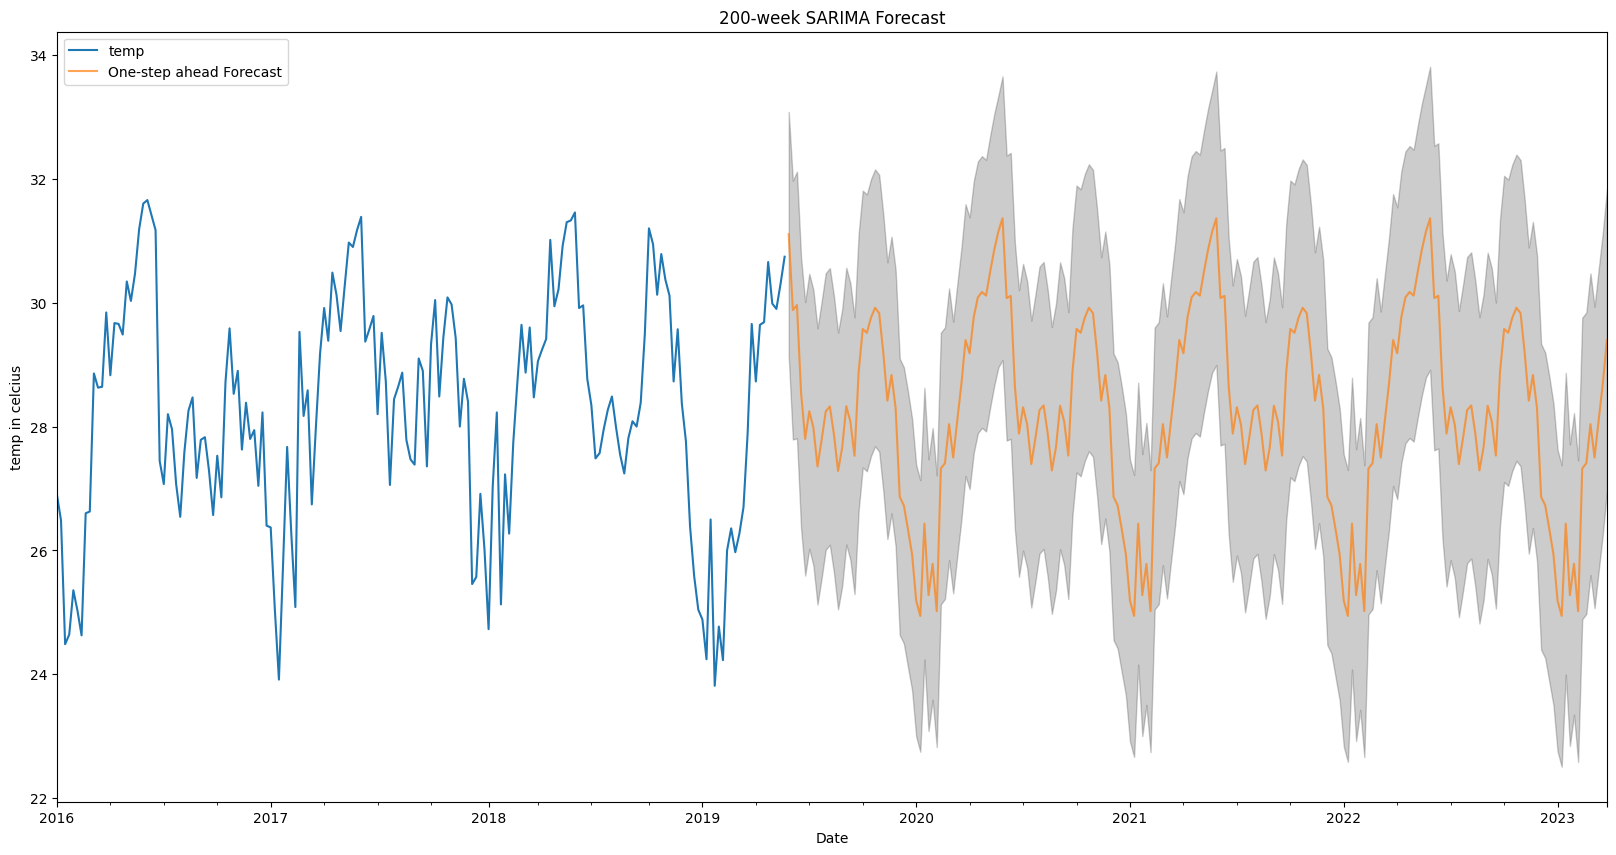

In [16]:
ax = train_df['2016-01-03':].plot(label='observed', figsize=(20, 10))
next200w.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(next200w_ci.index,
                next200w_ci.iloc[:, 0],
                next200w_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('temp in celcius')
plt.title('200-week SARIMA Forecast')
plt.legend()
plt.show()

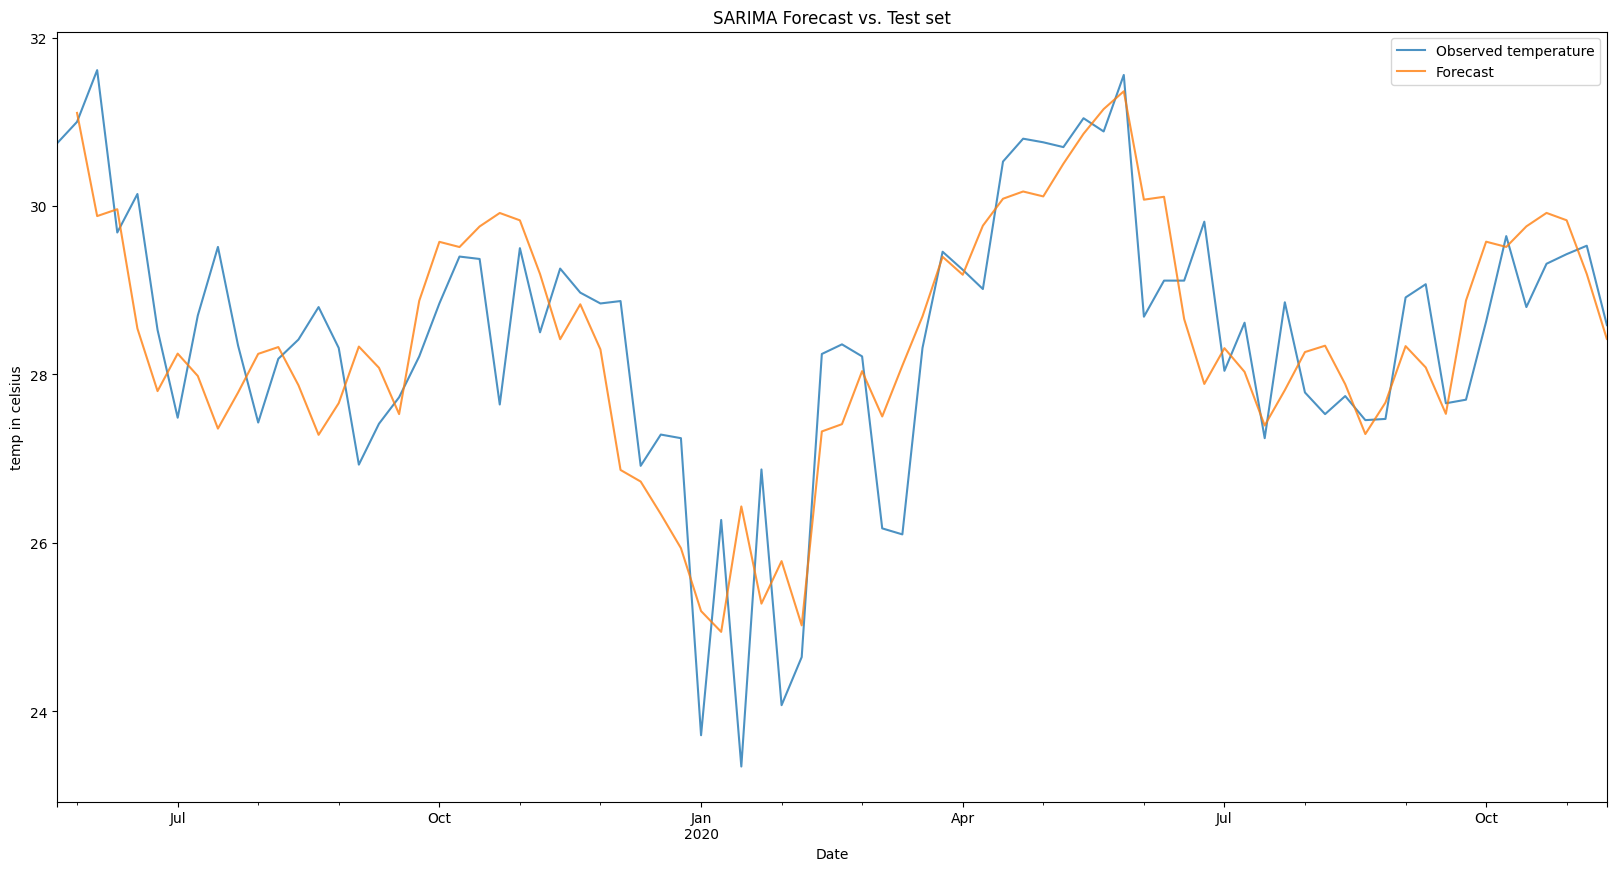

In [17]:
# plot the whole temperatures observed (temp) and the forecast tpgether
temp_temp_weekly = temp_weekly
temp_temp_weekly.rename(columns={'temp': 'Observed temperature'}, inplace=True)
ax = temp_temp_weekly.plot(label='observed temp', figsize=(20, 10), alpha=.8)
next200w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8)
ax.set_xlabel('Date')
ax.set_xlim('2019-05-26', '2020-11-15')
ax.set_ylabel('temp in celsius')
plt.title('SARIMA Forecast vs. Test set')
plt.legend()
plt.show()

In [18]:
# calculate rmse
rmse_sarima = np.sqrt(mean_squared_error(test_df, futureDF_forecast[:77]))
print('SARIMA - Test RMSE: %.3f' % rmse_sarima)

SARIMA - Test RMSE: 0.994


##Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_3r8dtr/uir1gawu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_3r8dtr/kn8cfe0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70809', 'data', 'file=/tmp/tmp9_3r8dtr/uir1gawu.json', 'init=/tmp/tmp9_3r8dtr/kn8cfe0h.json', 'output', 'file=/tmp/tmp9_3r8dtr/prophet_model51s119fz/prophet_model-20250326094216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


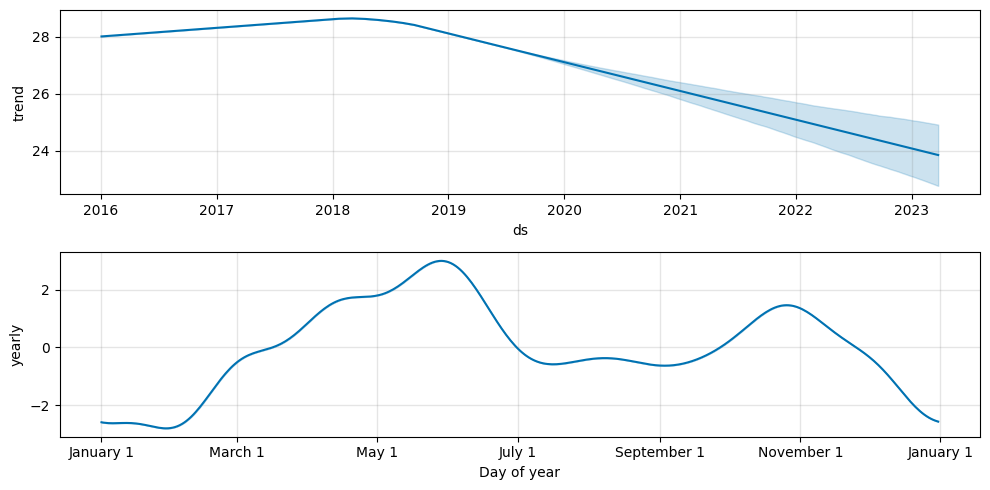

In [19]:
train_prophet = train_df.reset_index()
train_prophet.columns = ['ds', 'y']
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(train_prophet)

forecast_steps = 200
future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='W')
forecast_prophet = prophet_model.predict(future)

fig = plot_components(prophet_model, forecast_prophet, figsize=(10,5))
fig.show()

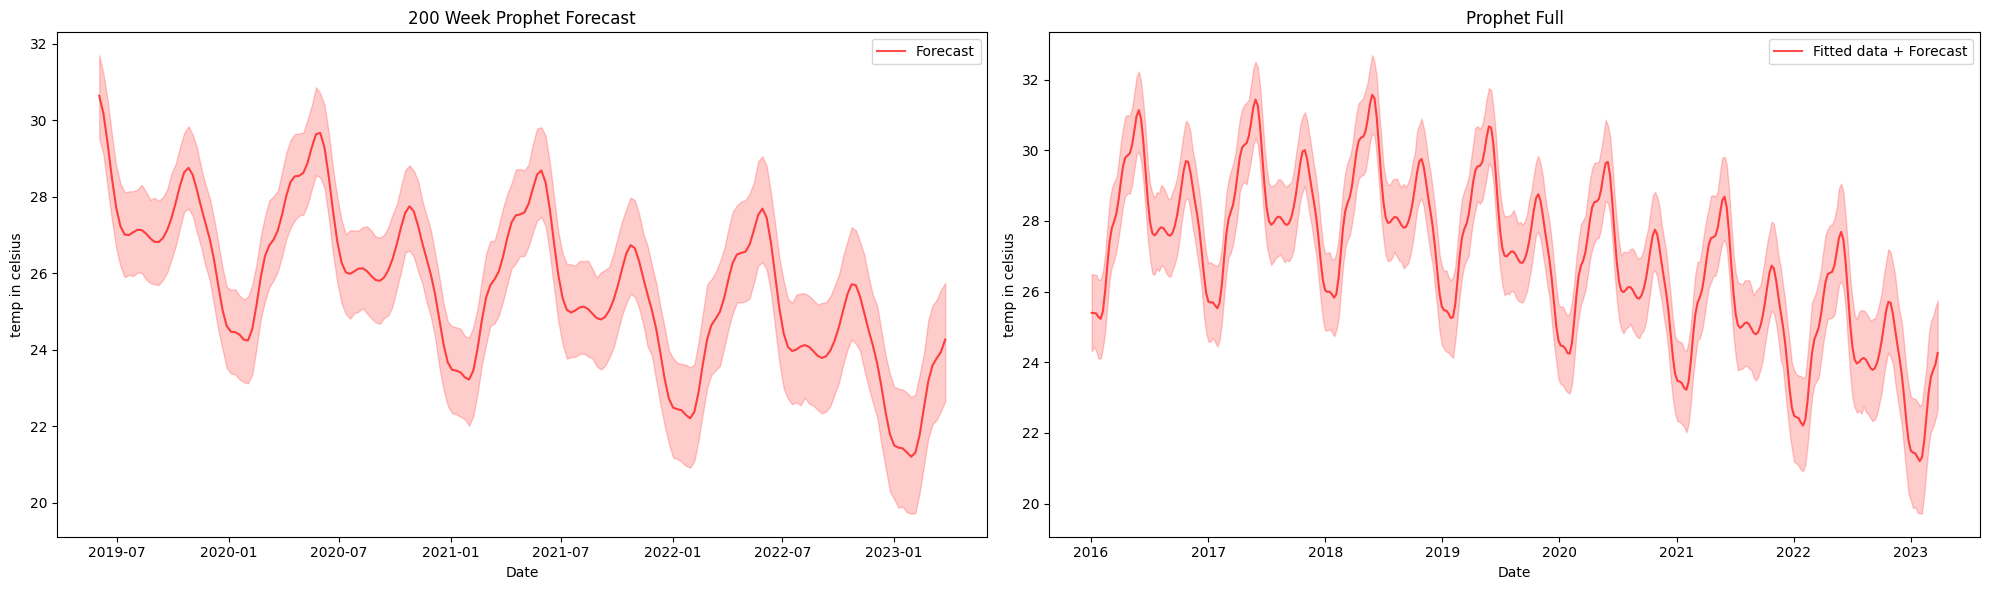

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(forecast_prophet['ds'][-forecast_steps:], forecast_prophet['yhat'][-forecast_steps:], label='Forecast', color='red', alpha=0.7)
ax1.fill_between(forecast_prophet['ds'][-forecast_steps:],
                 forecast_prophet['yhat_lower'][-forecast_steps:],
                 forecast_prophet['yhat_upper'][-forecast_steps:],
                 color='red', alpha=0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('temp in celsius')
ax1.set_title('200 Week Prophet Forecast')
ax1.legend()

ax2.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
ax2.fill_between(forecast_prophet['ds'],
                 forecast_prophet['yhat_lower'],
                 forecast_prophet['yhat_upper'],
                 color='red', alpha=0.2)
ax2.set_xlabel('Date')
ax2.set_ylabel('temp in celsius')
ax2.set_title('Prophet Full')
ax2.legend()

plt.tight_layout()
plt.show()

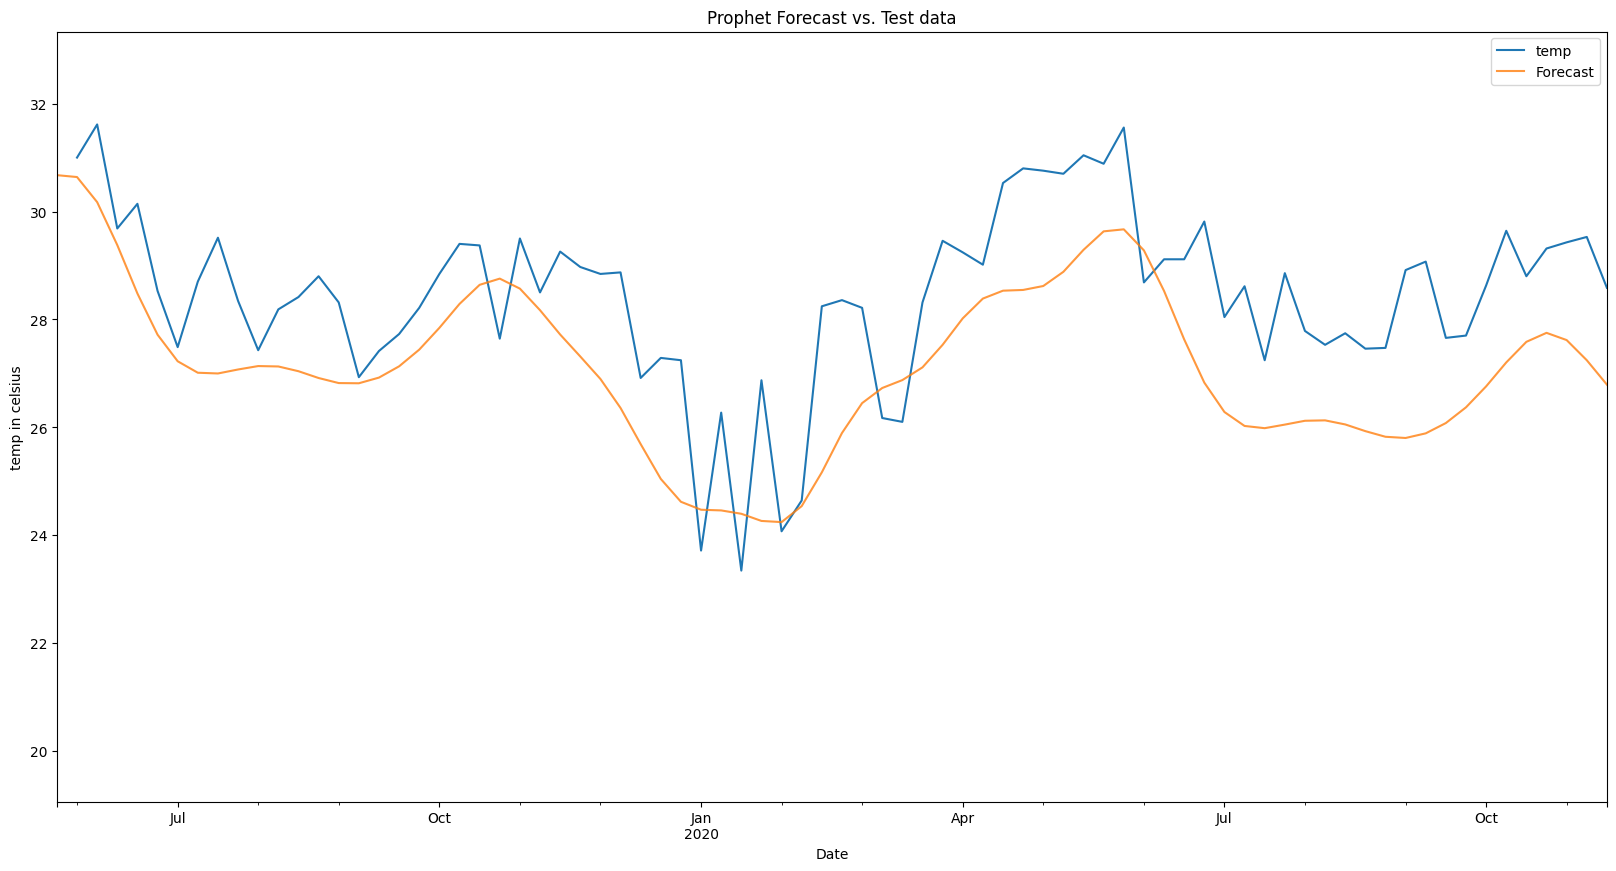

In [22]:
# prophet with observed train
ax = test_df.plot(label='temp', figsize=(20, 10))
forecast_prophet.plot(x='ds', y='yhat', ax=ax, label='Forecast', alpha=.8)
numerical_ds = pd.to_numeric(forecast_prophet['ds']).values

ax.fill_between(numerical_ds,
                forecast_prophet['yhat_lower'],
                forecast_prophet['yhat_upper'], color='k', alpha=.8)

ax.set_xlabel('Date')
ax.set_ylabel('temp in celsius')
ax.set_xlim('2019-05-26', '2020-11-15')
plt.title('Prophet Forecast vs. Test data')
plt.legend()
plt.show()

In [23]:
filtered_forecast = forecast_prophet[
    (forecast_prophet['ds'] > '2019-05-26') & (forecast_prophet['ds'] <= '2020-11-15')
]

In [24]:
# calculate rmse
rmse_prophet = np.sqrt(mean_squared_error(test_df, filtered_forecast['yhat']))
print('Prophet - Test RMSE: %.3f' % rmse_prophet)

Prophet - Test RMSE: 1.678


##Exponential Smoothing

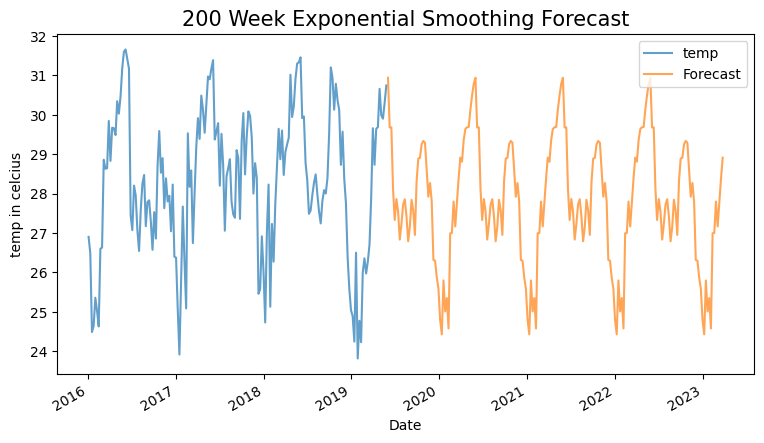

In [25]:
# implementing the Holt-Winters Exponential Smoothing model
smooth_e = ExponentialSmoothing(train_df, seasonal_periods=52, seasonal='add')
smooth_e_fit = smooth_e.fit()

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(train_df, label="temp", alpha=.7)
smooth_e_fit.forecast(200).plot(ax=ax, label="Forecast", alpha=.7)
ax.set_xlabel("Date")
ax.set_ylabel("temp in celcius")
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.title("200 Week Exponential Smoothing Forecast", fontsize=15)
plt.show()

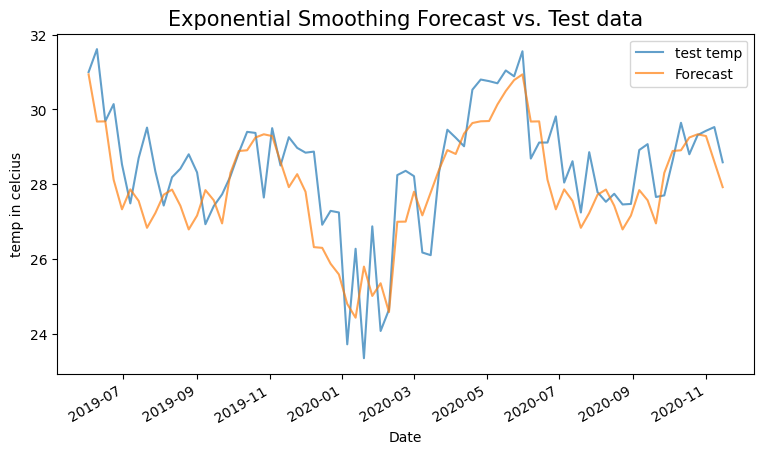

In [26]:
# forecast vs. test set
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(test_df, label="test temp", alpha=.7)
smooth_e_fit.forecast(len(test_df)).plot(ax=ax, label="Forecast", alpha=.7)
ax.set_xlabel("Date")
ax.set_ylabel("temp in celcius")
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.title("Exponential Smoothing Forecast vs. Test data", fontsize=15)
plt.show()

In [27]:
# calculate rmse
rmse_exs = np.sqrt(mean_squared_error(test_df, smooth_e_fit.forecast(len(test_df))))
print('Exponential Smoothing - Test RMSE: %.3f' % rmse_exs)

Exponential Smoothing - Test RMSE: 1.099


In [28]:
smooth_e_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     temp   No. Observations:                  178
Model:             ExponentialSmoothing   SSE                             99.368
Optimized:                         True   AIC                              4.234
Trend:                             None   BIC                            176.050
Seasonal:                      Additive   AICC                            56.994
Seasonal Periods:                    52   Date:                 Wed, 26 Mar 2025
Box-Cox:                          False   Time:                         09:42:18
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3266710                alpha                 True
smoothing_seasonal           6.3887e-09                gamma                 True
initial_level                 28.551769                  l.0                 True
initial_seasons.0            -2.2459173                  s.0                 True
initial_seasons.1            -3.0353000                  s.1                 True
initial_seasons.2            -3.4032398                  s.2                 True
initial_seasons.3            -2.0355012                  s.3                 True
initial_seasons.4            -2.8212367                  s.4                 True
initial_seasons.5            -2.4820825                  s.5                 True
initial_seasons.6            -3.2536126                  s.6                 True
initial_seasons.7            -0.8358475                  s.7                 True
initial_seasons.8            -0.8323757                  s.8                 True
initial_seasons.9            -0.0324544                  s.9                 True
initial_seasons.10           -0.6646937                 s.10                 True
initial_seasons.11           -0.0540775                 s.11                 True
initial_seasons.12            0.5565232                 s.12                 True
initial_seasons.13            1.0813888                 s.13                 True
initial_seasons.14            0.9777099                 s.14                 True
initial_seasons.15            1.5239948                 s.15                 True
initial_seasons.16            1.8060375                 s.16                 True
initial_seasons.17            1.8523202                 s.17                 True
initial_seasons.18            1.8593665                 s.18                 True
initial_seasons.19            2.3020936                 s.19                 True
initial_seasons.20            2.6627269                 s.20                 True
initial_seasons.21            2.9554980                 s.21                 True
initial_seasons.22            3.1077241                 s.22                 True
initial_seasons.23            1.8457207                 s.23                 True
initial_seasons.24            1.8503485                 s.24                 True
initial_seasons.25            0.2882644                 s.25                 True
initial_seasons.26           -0.5023452                 s.26                 True
initial_seasons.27            0.0308263                 s.27                 True
initial_seasons.28           -0.2788153                 s.28                 True
initial_seasons.29           -0.9979736                 s.29                 True
initial_seasons.30           -0.6028713                 s.30                 True
initial_seasons.31           -0.1125324                 s.31                 True
initial_seasons.32        

# Part 3 - Exogenous Variable

Now we'll try to use oter variables to help us more accurately predict the future temperature in Mumbai.

In [58]:
new_df = rainfall[["temp", "humidity", "solarradiation", "precipprob","sealevelpressure", "winddir", "dew"]]
new_df.dropna(inplace=True)
new_df.index = pd.to_datetime(new_df.index)
new_df_weekly = new_df.resample('W').mean()
new_df_weekly.dropna(inplace=True)

In [59]:
## plotting the three variables on the same plot
temp_weekly = new_df_weekly["temp"]
humidity_weekly = new_df_weekly["humidity"]
solarradiation_weekly = new_df_weekly["solarradiation"]
precipprob_weekly = new_df_weekly["precipprob"]
sealevel_weekly = new_df_weekly["sealevelpressure"]
winddir_weekly = new_df_weekly["winddir"]
dew_weekly = new_df_weekly["dew"]

# find how relatd the variables are
corr_temp_humidity = temp_weekly.corr(humidity_weekly)
corr_temp_solarradiation = temp_weekly.corr(solarradiation_weekly)
corr_temp_precipprob = temp_weekly.corr(precipprob_weekly)
corr_temp_sealevel = temp_weekly.corr(sealevel_weekly)
corr_temp_winddir = temp_weekly.corr(winddir_weekly)
corr_temp_dew = temp_weekly.corr(dew_weekly)

print(f"Correlation between temperature and humidity: {corr_temp_humidity}")
print(f"Correlation between temperature and solar radiation: {corr_temp_solarradiation}")
print(f"Correlation between temperature and preciptation probability: {corr_temp_precipprob}")
print(f"Correlation between temperature and sea level pressure: {corr_temp_sealevel}")
print(f"Correlation between temperature and wind direction: {corr_temp_winddir}")
print(f"Correlation between temperature and dew point: {corr_temp_dew}")

Correlation between temperature and humidity: 0.2185885889865907
Correlation between temperature and solar radiation: 0.2763832230519221
Correlation between temperature and preciptation probability: 0.1530065045889833
Correlation between temperature and sea level pressure: -0.38596689391769545
Correlation between temperature and wind direction: 0.30504802603463305
Correlation between temperature and dew point: 0.6013989361008183


We'll choose to work with the exogenous variables of dew. Seeing it will probably will be the one that will most help us wen it comes to forecasting the temperature.

Following, we'll use the previous used models (SARIMA, Prophet and Exponential Smoothing) implementing the additive variables


In [60]:
new_df_weekly.drop(columns=["precipprob", "humidity", "solarradiation", "sealevelpressure", "winddir"], inplace=True)

## SARIMA with exogenous variable

In [61]:
target_temp = new_df_weekly["temp"]
exog_dew = new_df_weekly["dew"]

train_ex = new_df_weekly[:length_train]
test_ex = new_df_weekly[length_train:]

train_target, test_target = target_temp[:length_train], target_temp[length_train:]
train_exog_dew, test_exog_dew = exog_dew[:length_train], exog_dew[length_train:]

We'll test the same parameters we did before. Given the explanations on the possible parameters chosen come from the weekly temperature dataset and that has not been messed with (changed).

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -191.021
Date:                            Wed, 26 Mar 2025   AIC                            392.043
Time:                                    09:42:39   BIC                            406.184
Sample:                                01-03-2016   HQIC                           397.788
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1072      0.052      2.057      0.040       0.005       0.209
ar.L1          0.3690      0.100   

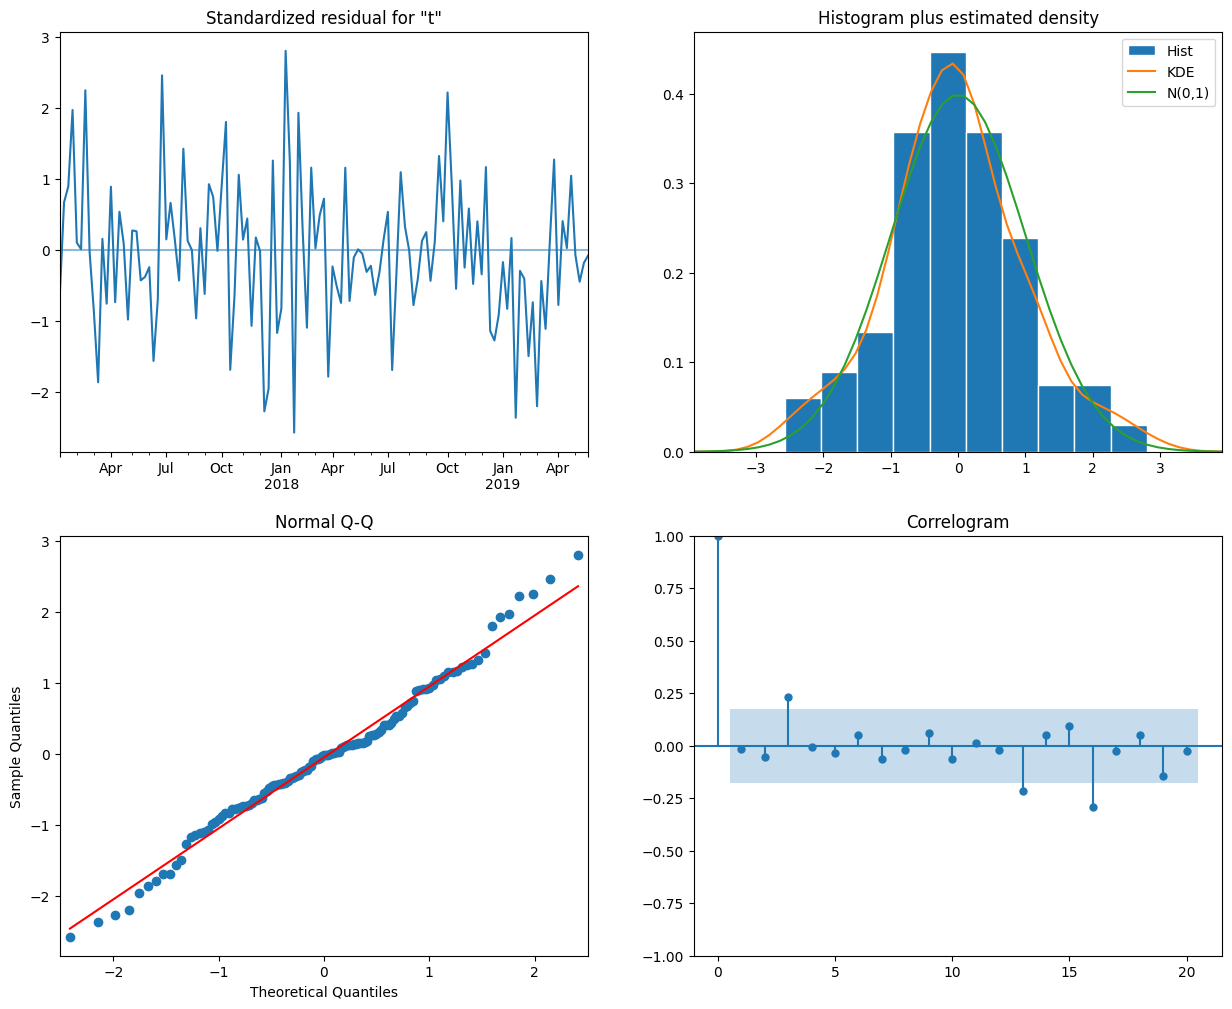

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -201.972
Date:                             Wed, 26 Mar 2025   AIC                            411.944
Time:                                     09:42:41   BIC                            423.258
Sample:                                 01-03-2016   HQIC                           416.540
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.0423      0.052      0.811      0.417      -0.060       0.145
ar.L1          0.3582      

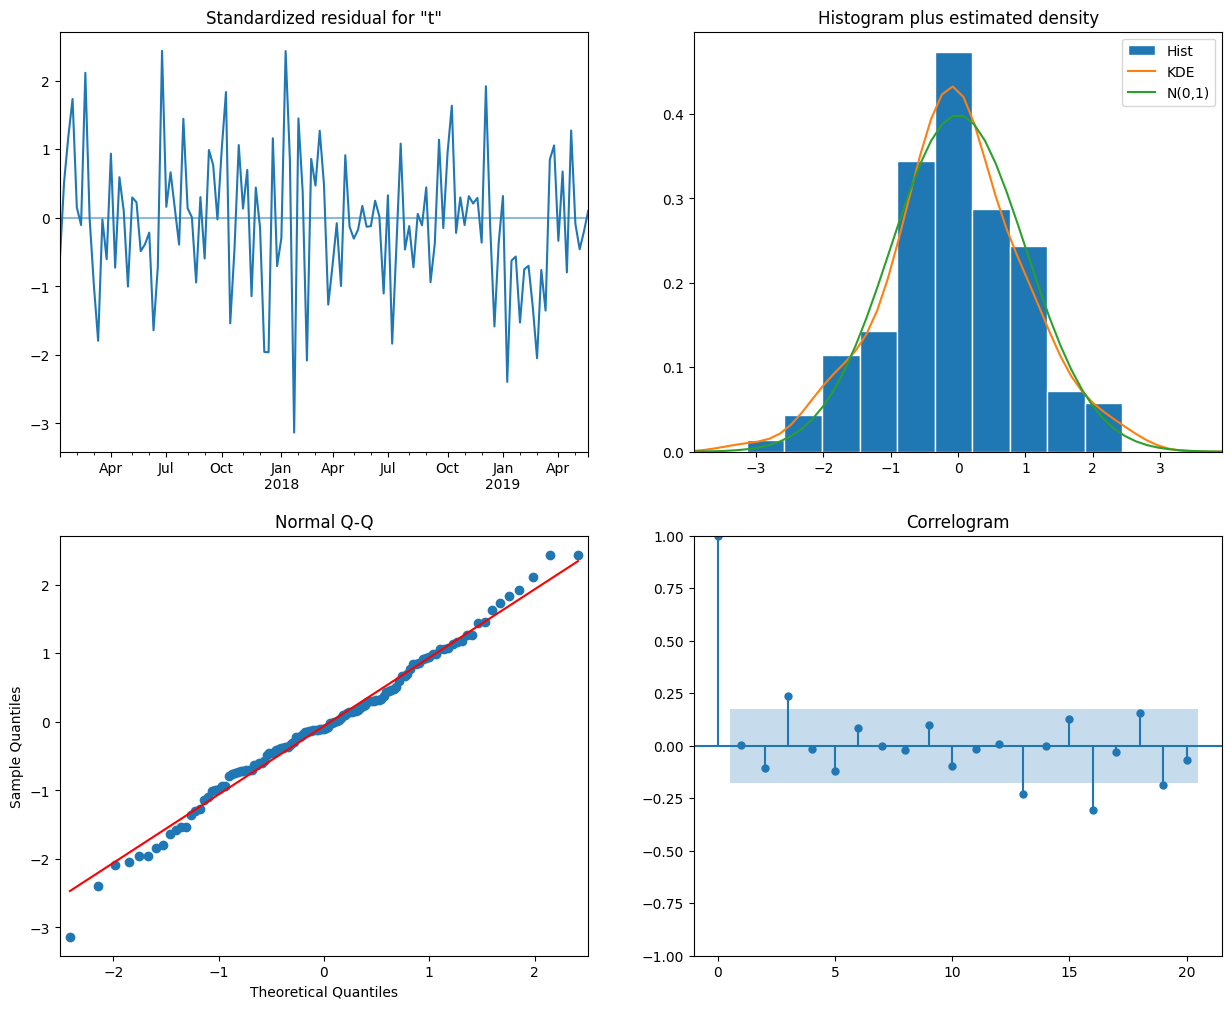

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -190.901
Date:                            Wed, 26 Mar 2025   AIC                            393.802
Time:                                    09:43:25   BIC                            410.771
Sample:                                01-03-2016   HQIC                           400.696
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1031      0.052      1.995      0.046       0.002       0.204
ar.L1          0.3716      0.099   

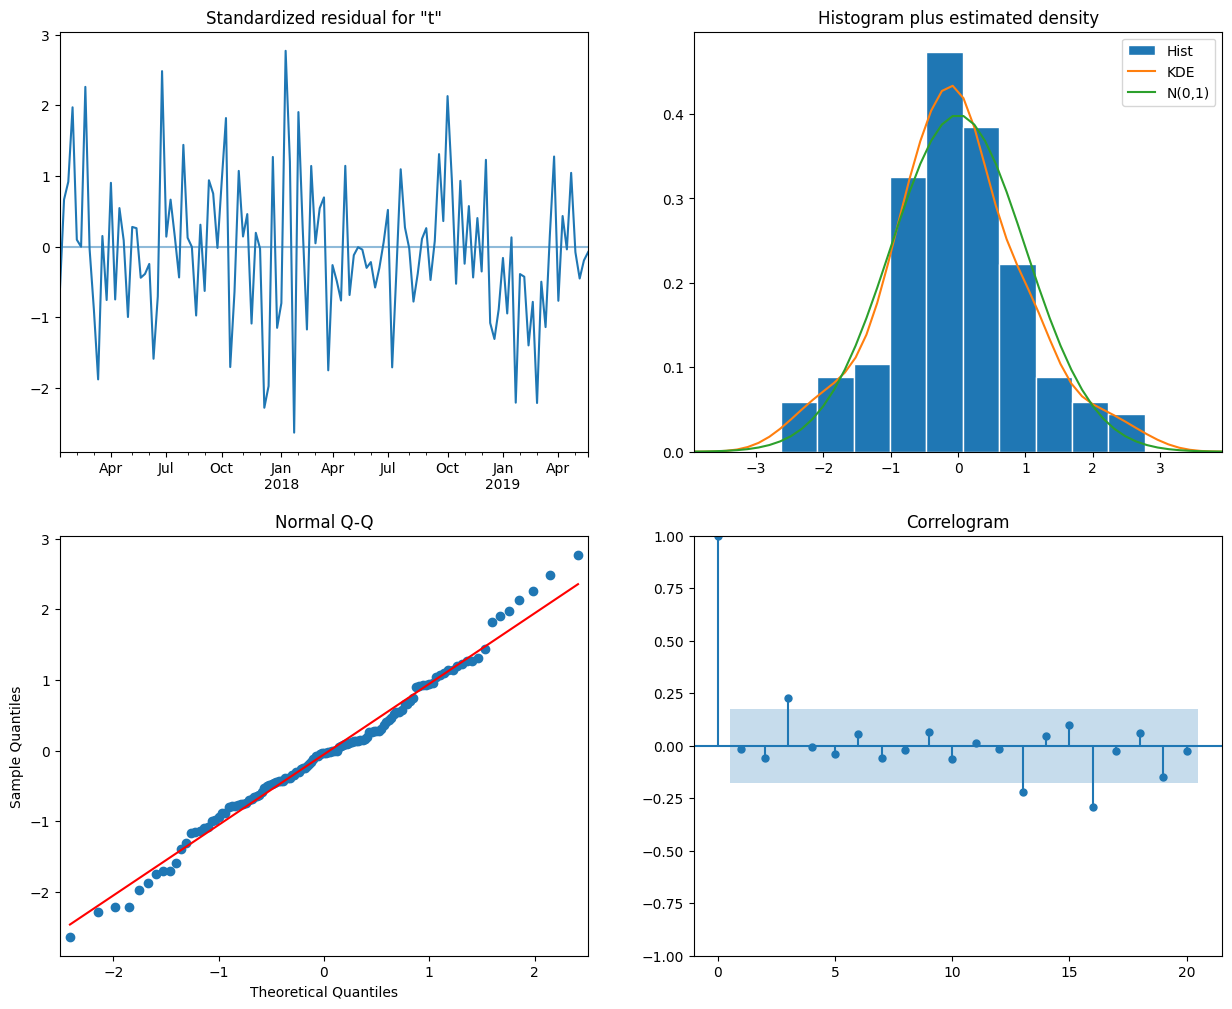

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                -192.708
Date:                             Wed, 26 Mar 2025   AIC                            395.416
Time:                                     09:43:34   BIC                            409.558
Sample:                                 01-03-2016   HQIC                           401.161
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.0762      0.052      1.451      0.147      -0.027       0.179
ar.L1          0.3836      

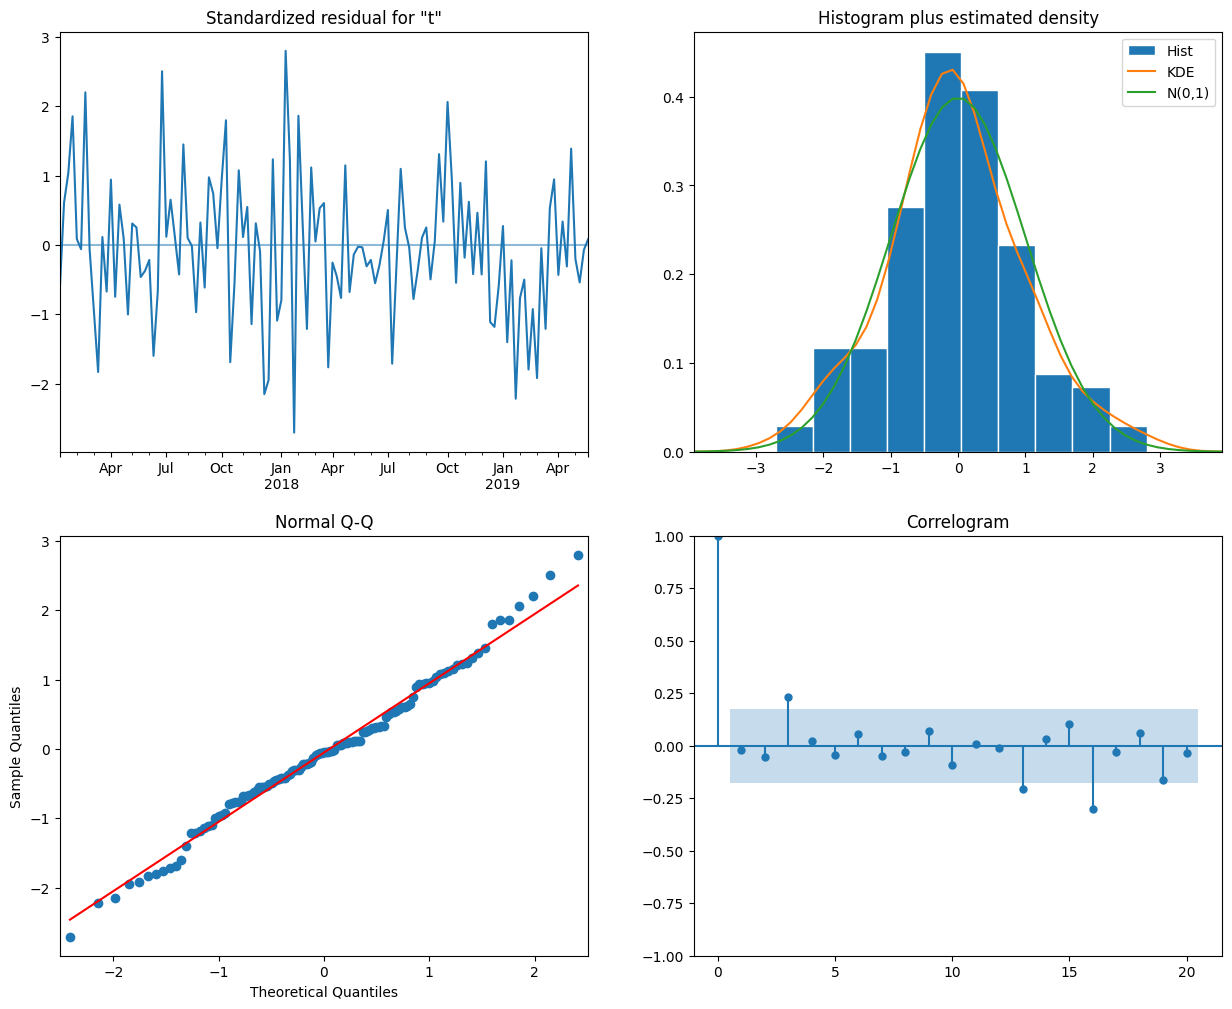

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -189.460
Date:                            Wed, 26 Mar 2025   AIC                            388.920
Time:                                    09:44:07   BIC                            403.102
Sample:                                01-03-2016   HQIC                           394.682
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1124      0.055      2.032      0.042       0.004       0.221
ar.L1          0.7090      0.128   

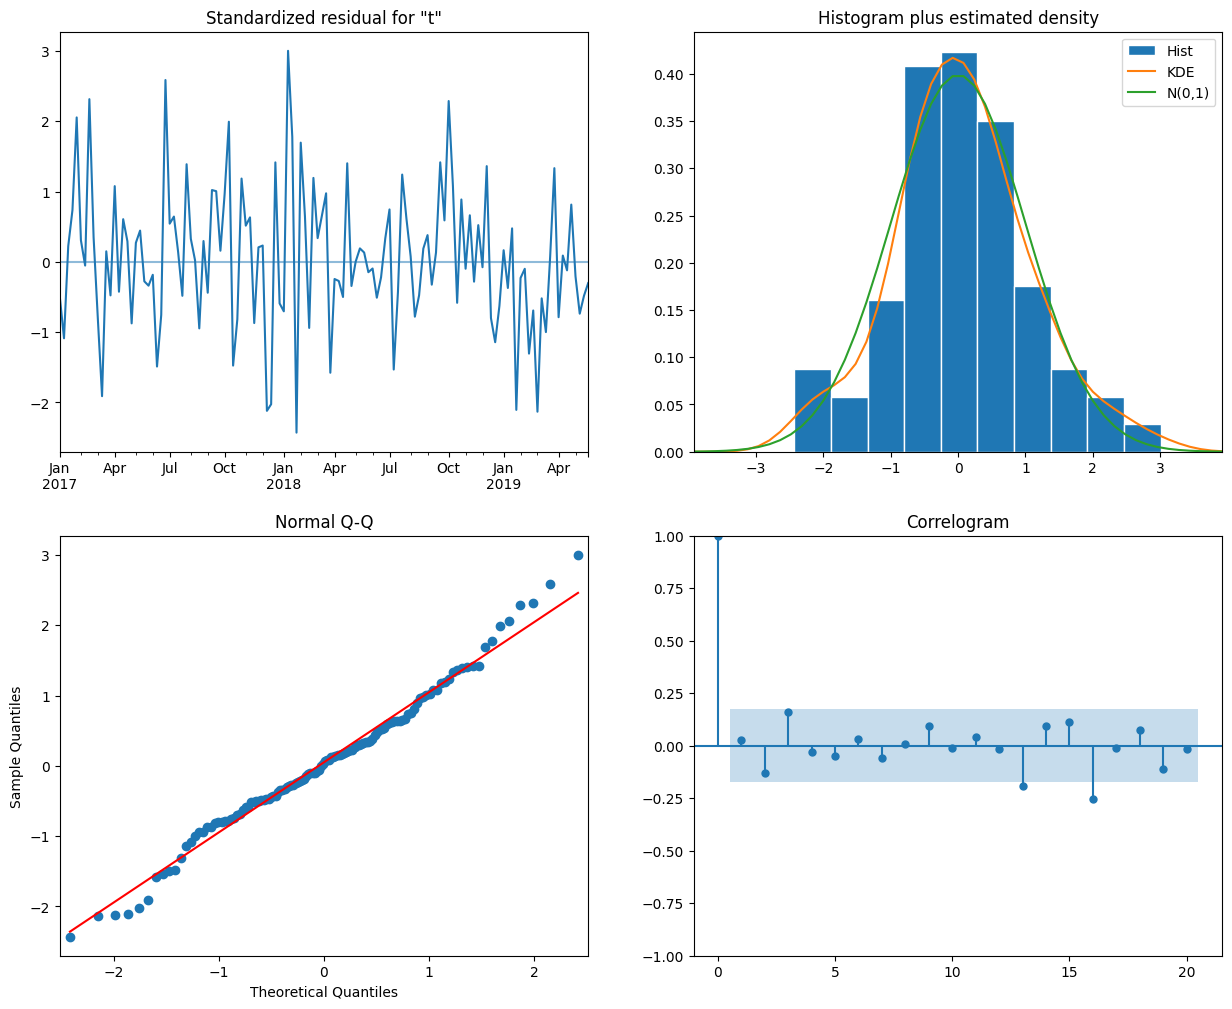

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 52)   Log Likelihood                -202.007
Date:                             Wed, 26 Mar 2025   AIC                            412.014
Time:                                     09:44:09   BIC                            423.359
Sample:                                 01-03-2016   HQIC                           416.623
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.0591      0.053      1.116      0.264      -0.045       0.163
ar.L1          0.6038      

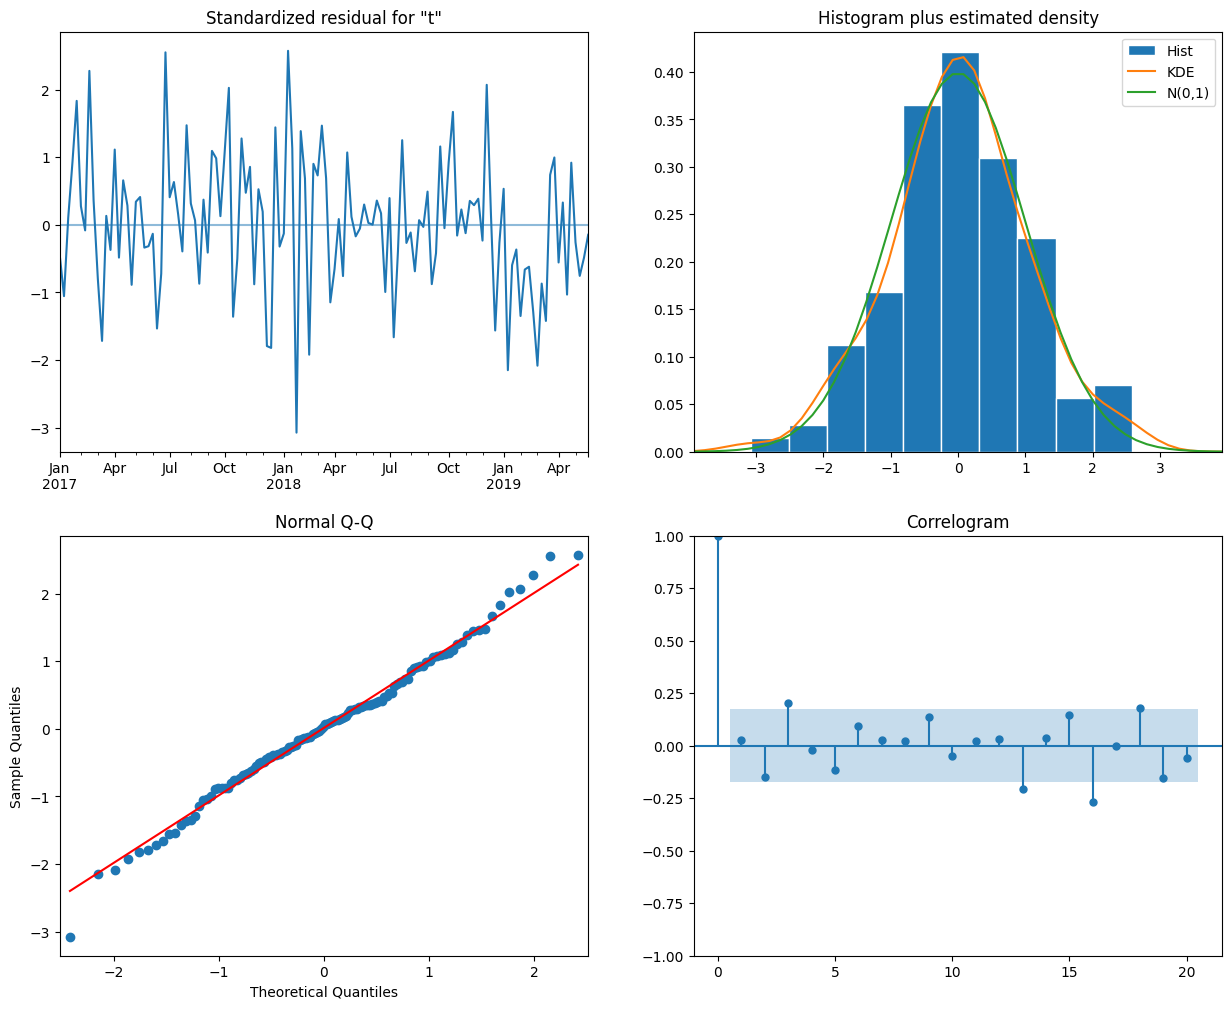

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -189.436
Date:                            Wed, 26 Mar 2025   AIC                            390.872
Time:                                    09:44:37   BIC                            407.890
Sample:                                01-03-2016   HQIC                           397.786
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1099      0.055      1.995      0.046       0.002       0.218
ar.L1          0.7048      0.129   

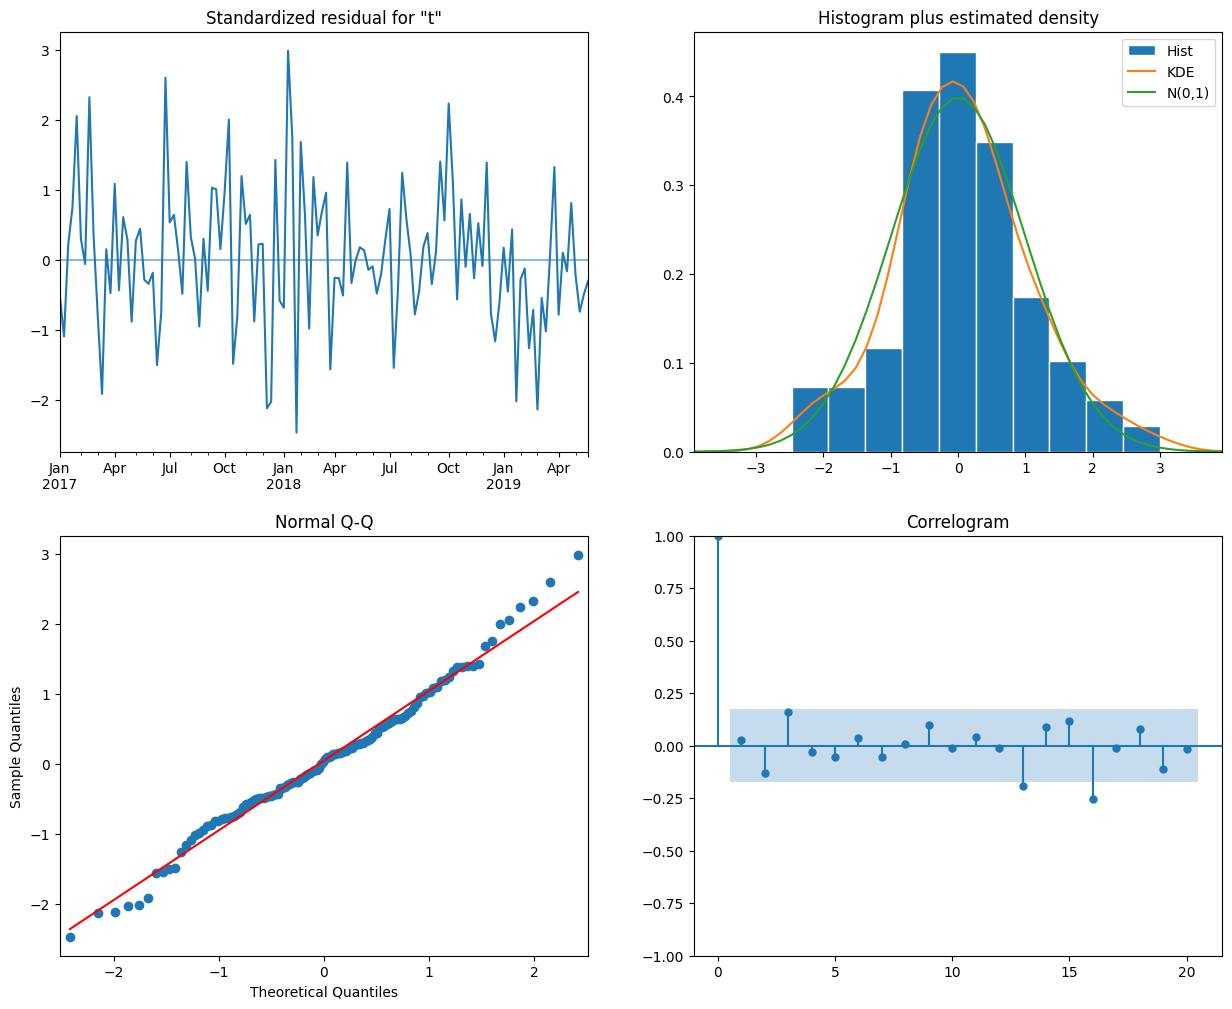

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood                -191.319
Date:                             Wed, 26 Mar 2025   AIC                            392.638
Time:                                     09:44:47   BIC                            406.820
Sample:                                 01-03-2016   HQIC                           398.400
                                      - 05-26-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.0794      0.055      1.434      0.152      -0.029       0.188
ar.L1          0.7443      

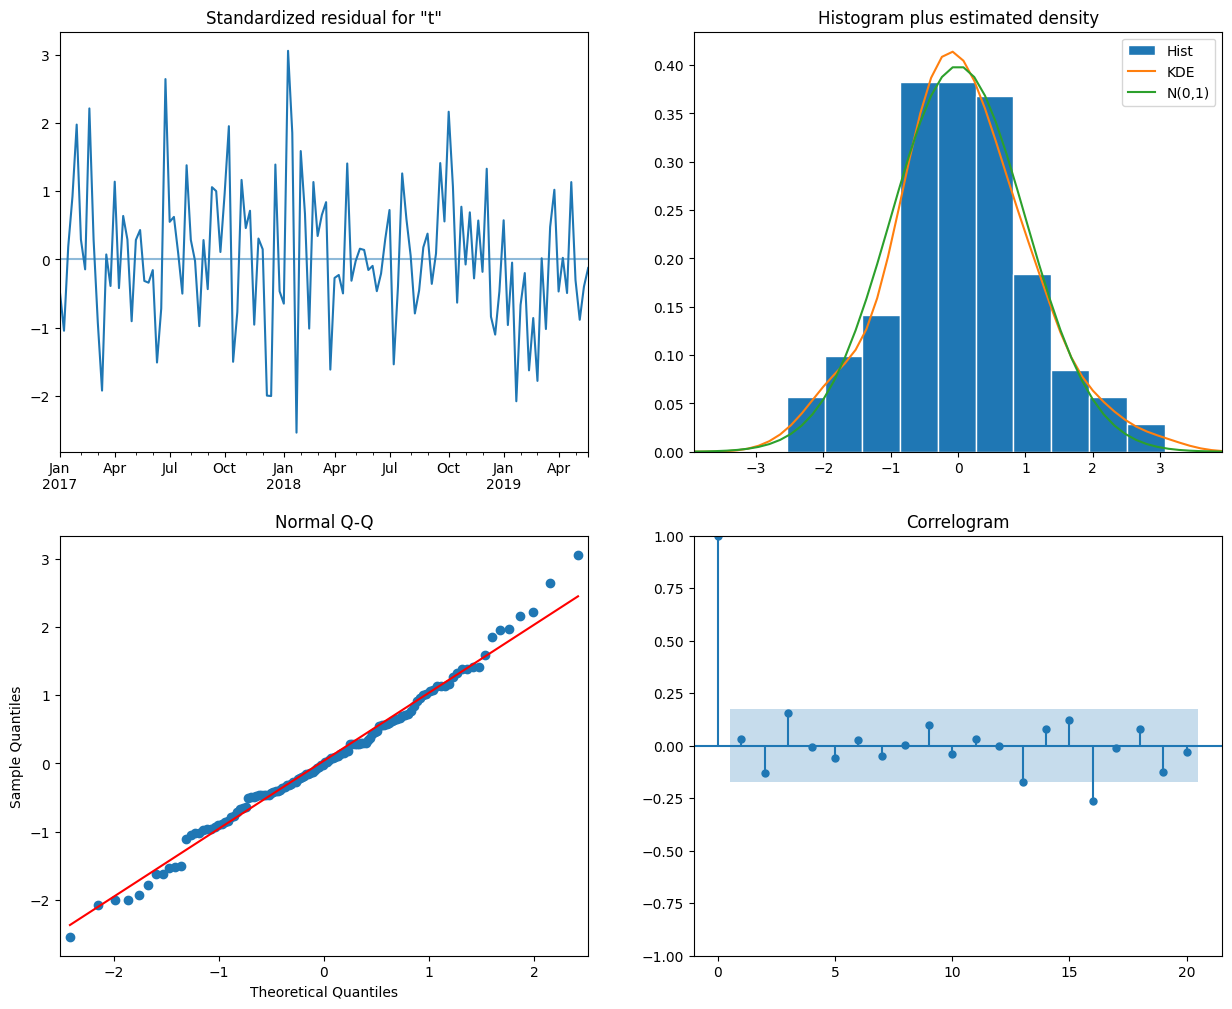

In [33]:
bics_w_exog = {}
aics_w_exog = {}
for param in sarima_params:
    model = SARIMAX(train_target, exog = train_exog_dew, order=param[0], seasonal_order=param[1])
    model_fit = model.fit(disp=False)
    bics_w_exog[f'BIC {param[0]} {param[1]}'] = model_fit.bic
    aics_w_exog[f'AIC {param[0]} {param[1]}'] = model_fit.aic
    print(model_fit.summary())
    model_fit.plot_diagnostics(lags=20, figsize=(15, 12))
    plt.show()

In [34]:
bics_sorted = {k: v for k, v in sorted(bics_w_exog.items(), key=lambda item: item[1])}
aics_sorted = {k: v for k, v in sorted(aics_w_exog.items(), key=lambda item: item[1])}
print('BICs:')
for k, v in bics_sorted.items():
    print(f'{k}: {v}')
print('AICs:')
for k, v in aics_sorted.items():
    print(f'{k}: {v}')

BICs:
BIC (1, 0, 1) (0, 1, 1, 52): 403.1018370734464
BIC (1, 1, 1) (0, 1, 1, 52): 406.18424607096665
BIC (1, 0, 1) (1, 1, 0, 52): 406.8198094982634
BIC (1, 0, 1) (1, 1, 1, 52): 407.8899241224987
BIC (1, 1, 1) (1, 1, 0, 52): 409.55769499208077
BIC (1, 1, 1) (1, 1, 1, 52): 410.77141976700574
BIC (1, 1, 1) (0, 1, 0, 52): 423.2577150089111
BIC (1, 0, 1) (0, 1, 0, 52): 423.3589260804028
AICs:
AIC (1, 0, 1) (0, 1, 1, 52): 388.920427538689
AIC (1, 0, 1) (1, 1, 1, 52): 390.87223268078986
AIC (1, 1, 1) (0, 1, 1, 52): 392.04267738445515
AIC (1, 0, 1) (1, 1, 0, 52): 392.638399963506
AIC (1, 1, 1) (1, 1, 1, 52): 393.8015373431919
AIC (1, 1, 1) (1, 1, 0, 52): 395.41612630556926
AIC (1, 1, 1) (0, 1, 0, 52): 411.9444600597019
AIC (1, 0, 1) (0, 1, 0, 52): 412.01379845259686


                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  178
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -189.460
Date:                            Wed, 26 Mar 2025   AIC                            388.920
Time:                                    10:51:01   BIC                            403.102
Sample:                                01-03-2016   HQIC                           394.682
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1124      0.055      2.032      0.042       0.004       0.221
ar.L1          0.7090      0.128   

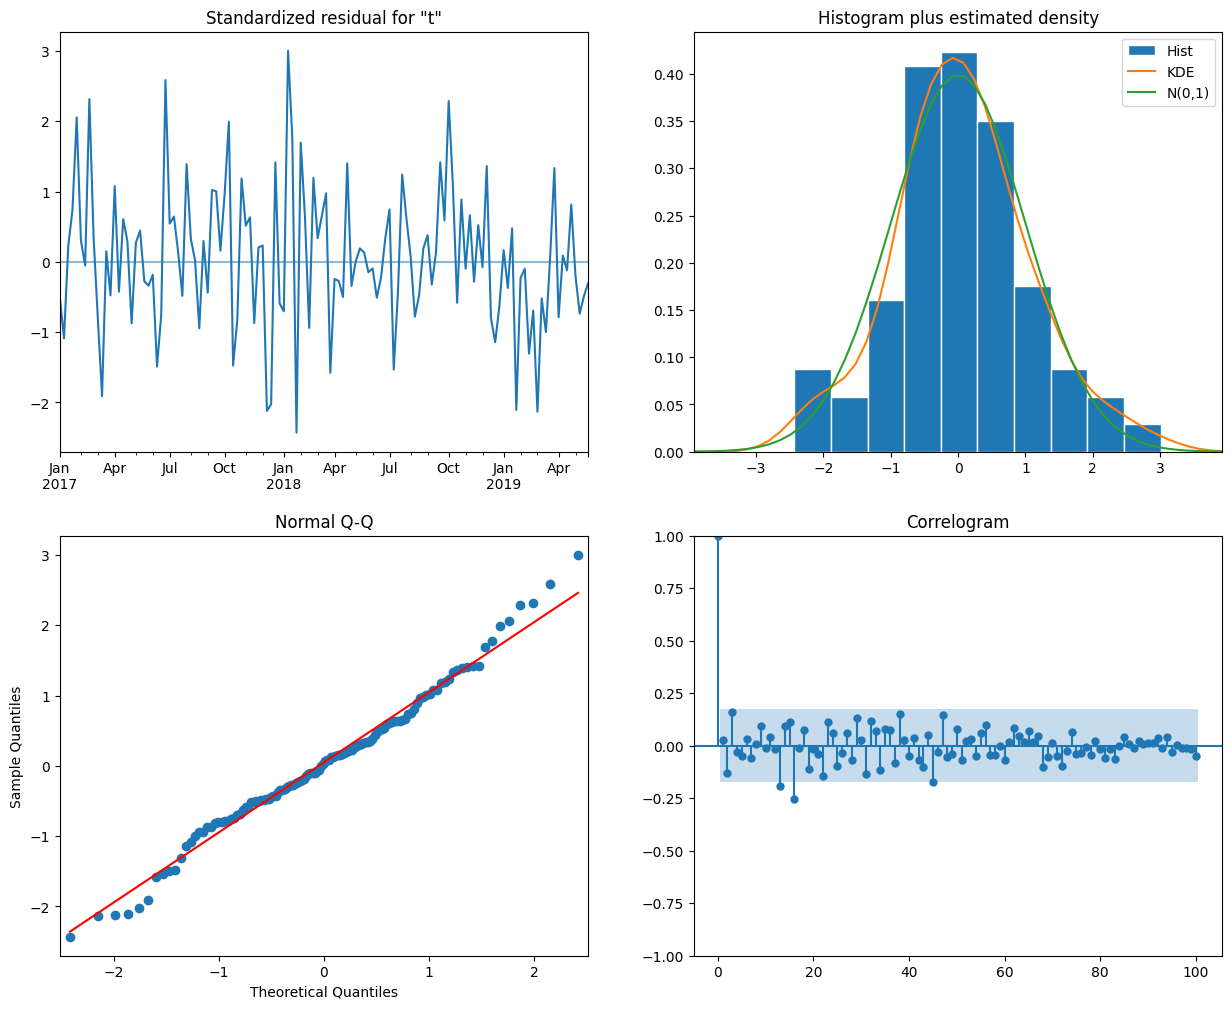

In [62]:
best_model = SARIMAX(train_target, exog = train_exog_dew, order=(1,0,1), seasonal_order=(0,1,1,52))
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())
best_model_fit.plot_diagnostics(lags=100, figsize=(15, 12))
plt.show()

In [36]:
forecast_steps = 200
known = test_exog_dew[:77]
reps = (200 + len(known) - 1)//len(known)
future_exog_dew = pd.Series(np.tile(known, reps)[:forecast_steps], index=pd.date_range(start='2019-06-02', periods=forecast_steps, freq='W'))
print(future_exog_dew)
next200w = best_model_fit.get_forecast(steps=forecast_steps, exog = future_exog_dew.values)
next200w_ci = next200w.conf_int()

futureDates = pd.date_range(start='2019-06-02', periods=forecast_steps, freq='W')
next200w_ci.index = futureDates

futureDF_forecast_ex = pd.DataFrame(next200w.predicted_mean, index=futureDates)

2019-06-02    25.028571
2019-06-09    25.857143
2019-06-16    25.742857
2019-06-23    25.757143
2019-06-30    25.514286
                ...    
2023-02-26    15.857143
2023-03-05    17.928571
2023-03-12    21.500000
2023-03-19    21.942857
2023-03-26    23.885714
Freq: W-SUN, Length: 200, dtype: float64


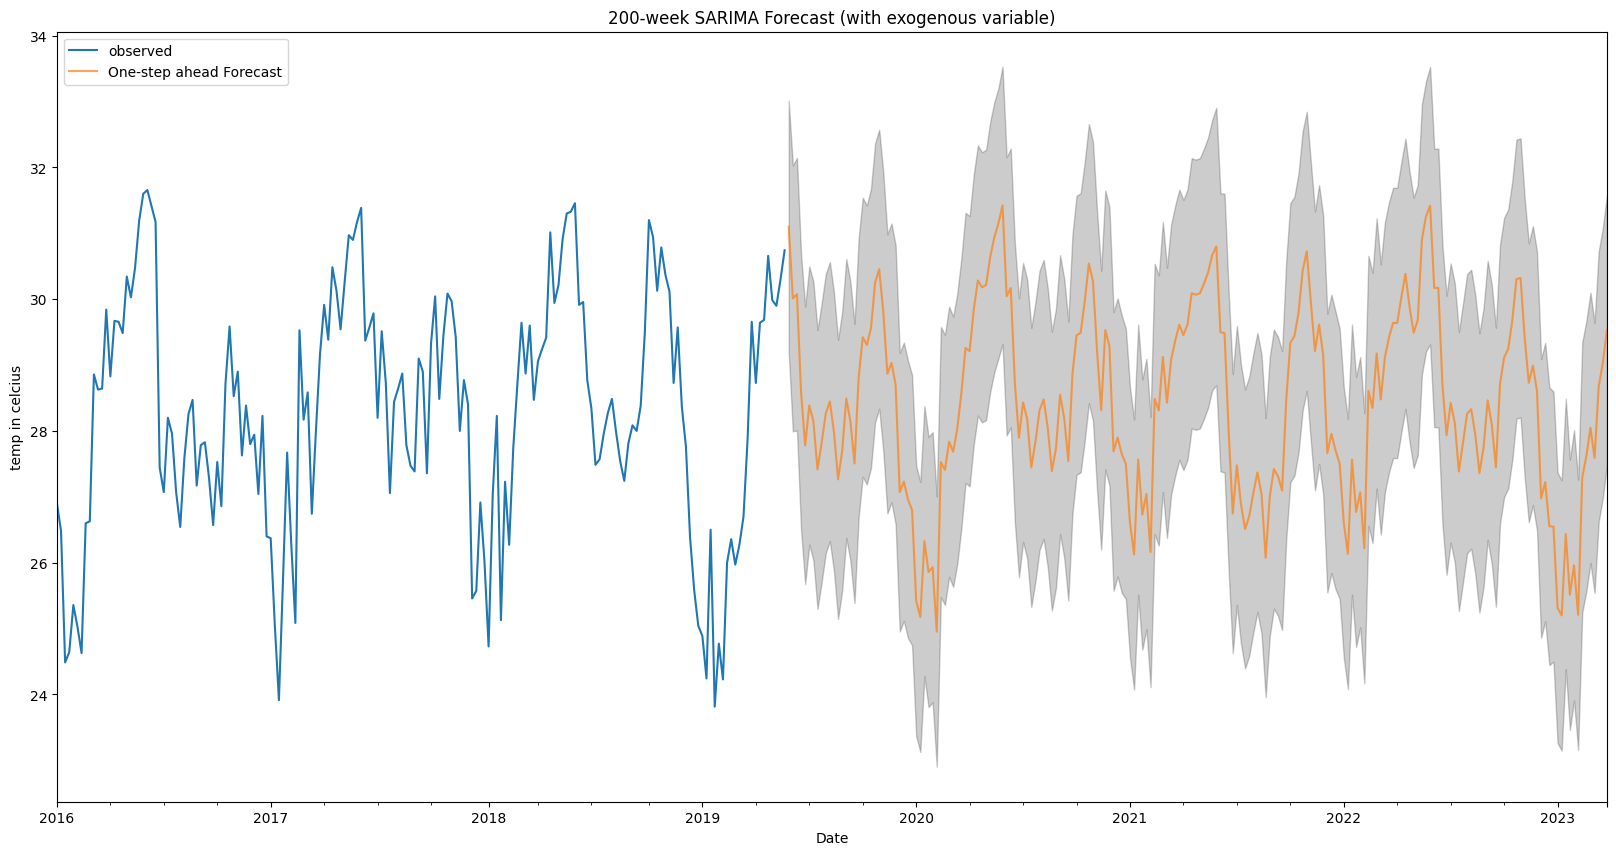

In [37]:
ax = train_target['2016-01-03':].plot(label='observed', figsize=(20, 10))
next200w.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(next200w_ci.index,
                next200w_ci.iloc[:, 0],
                next200w_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('temp in celcius')
plt.title('200-week SARIMA Forecast (with exogenous variable)')
plt.legend()
plt.show()

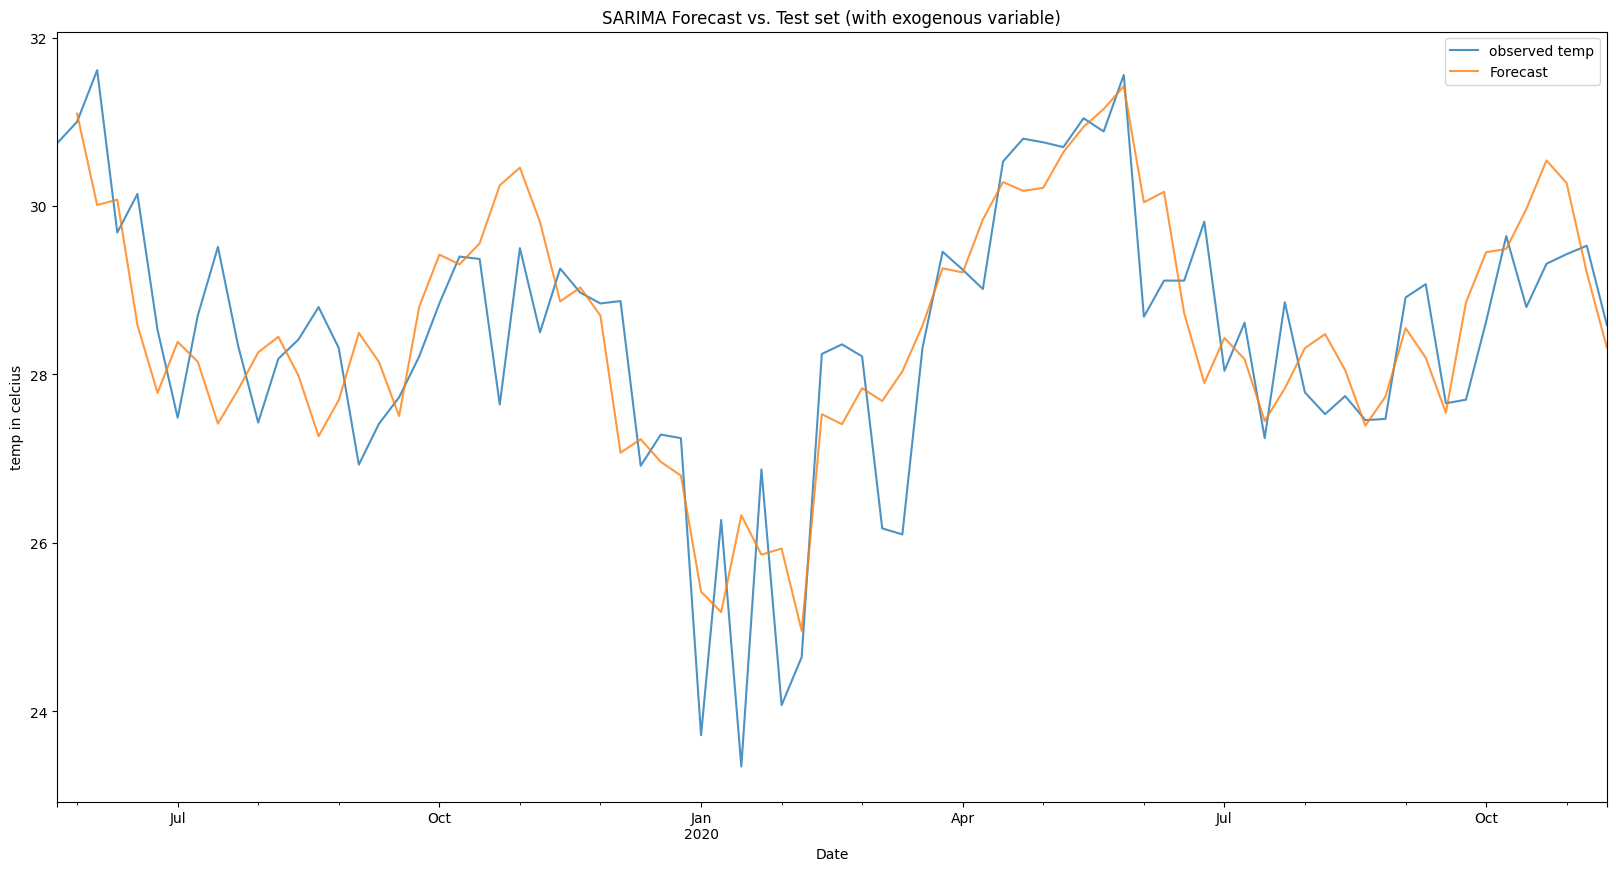

In [38]:
ax = temp_weekly.plot(label='observed temp', figsize=(20, 10), alpha=.8)
next200w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8)
ax.set_xlabel('Date')
ax.set_xlim('2019-05-26', '2020-11-15')
ax.set_ylabel('temp in celcius')
plt.title('SARIMA Forecast vs. Test set (with exogenous variable)')
plt.legend()
plt.show()

In [39]:
# calculate rmse
rmse_sarima_dew = np.sqrt(mean_squared_error(test_target, futureDF_forecast_ex[:77]))
print('SARIMA - dew - Test RMSE: %.3f' % rmse_sarima_dew)

SARIMA - dew - Test RMSE: 0.989


##Prophet with exogenous variable

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_3r8dtr/_nif2xjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_3r8dtr/wfcrjv15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50060', 'data', 'file=/tmp/tmp9_3r8dtr/_nif2xjw.json', 'init=/tmp/tmp9_3r8dtr/wfcrjv15.json', 'output', 'file=/tmp/tmp9_3r8dtr/prophet_modelbv8fchru/prophet_model-20250326094519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:45:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


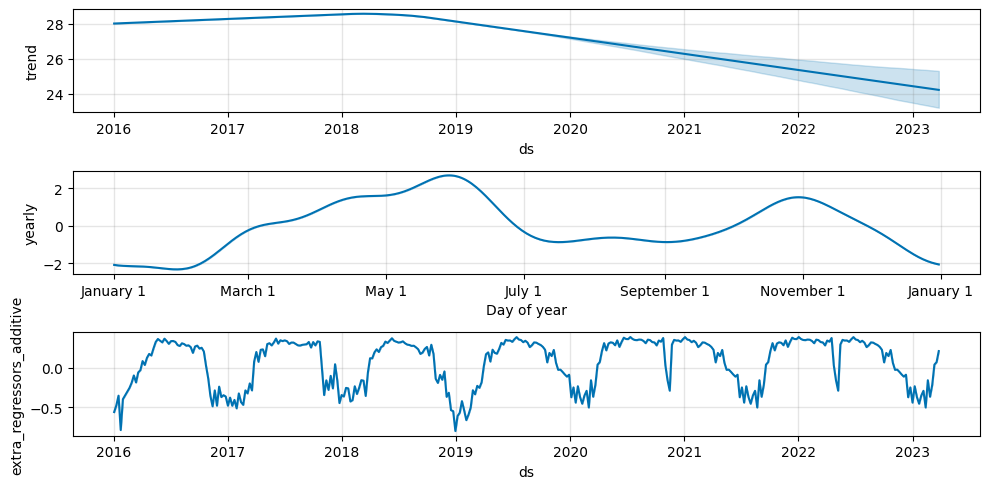

In [40]:
train_prophet_exog = pd.concat([train_target, train_exog_dew], axis=1).reset_index()
train_prophet_exog.columns = ['ds', 'y', 'dew']

prophet_model_exog = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model_exog.add_regressor('dew')
prophet_model_exog.fit(train_prophet_exog)

forecast_steps = 200
future_exog = prophet_model_exog.make_future_dataframe(periods = forecast_steps, freq='W')
all_exog_dew_until_2023 = pd.concat([train_exog_dew, future_exog_dew])
future_exog['dew'] = all_exog_dew_until_2023.values
future_exog['dew'] = future_exog['dew'].fillna(method='ffill')

forecast_prophet_exog = prophet_model_exog.predict(future_exog)

fig = plot_components(prophet_model_exog, forecast_prophet_exog, figsize=(10,5))
fig.show()

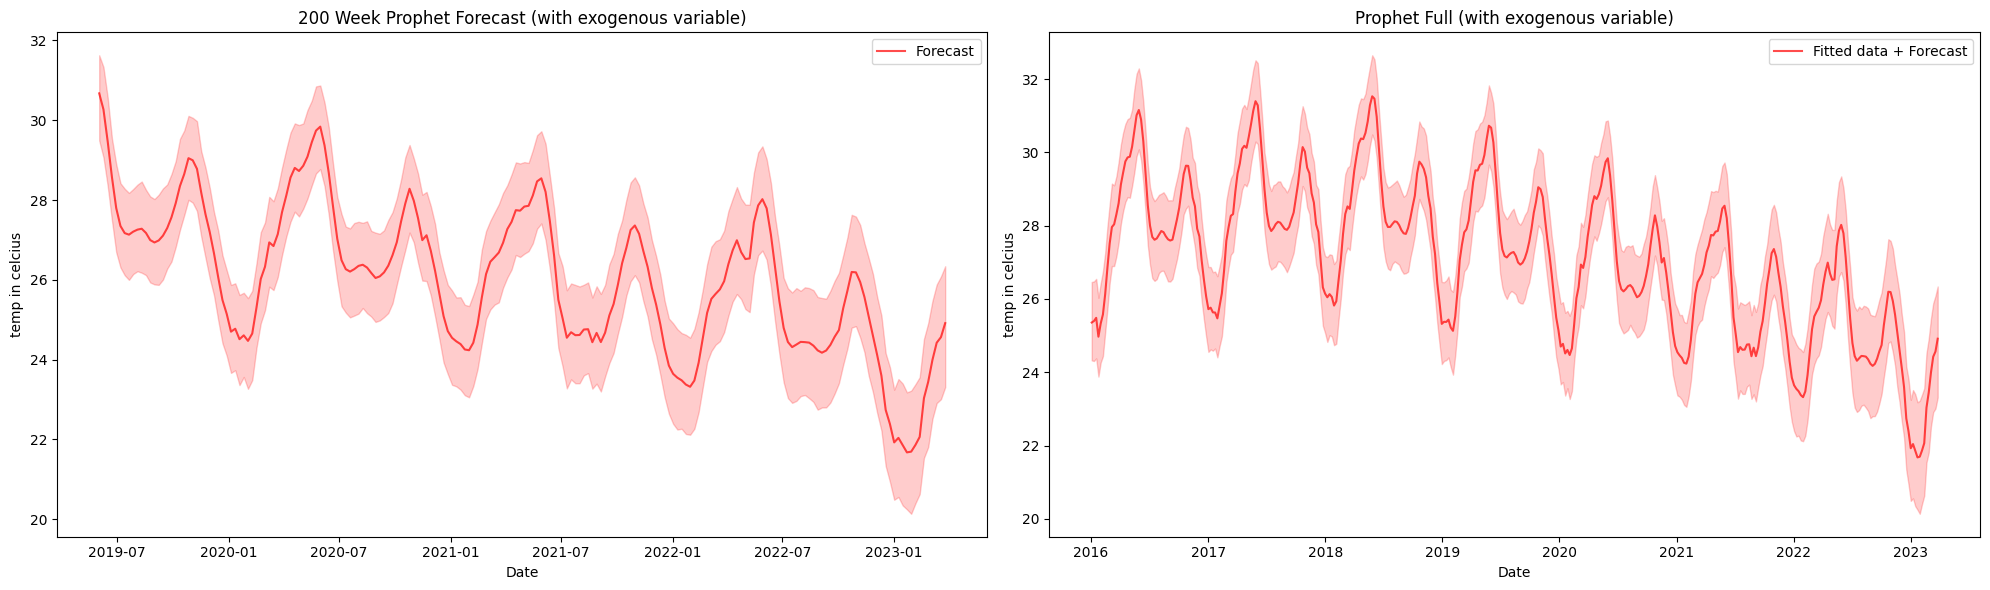

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(forecast_prophet_exog['ds'][-forecast_steps:], forecast_prophet_exog['yhat'][-forecast_steps:], label='Forecast', color='red', alpha=0.7)
ax1.fill_between(forecast_prophet_exog['ds'][-forecast_steps:],
                 forecast_prophet_exog['yhat_lower'][-forecast_steps:],
                 forecast_prophet_exog['yhat_upper'][-forecast_steps:],
                 color='red', alpha=0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('temp in celcius')
ax1.set_title('200 Week Prophet Forecast (with exogenous variable)')
ax1.legend()

ax2.plot(forecast_prophet_exog['ds'], forecast_prophet_exog['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
ax2.fill_between(forecast_prophet_exog['ds'],
                 forecast_prophet_exog['yhat_lower'],
                 forecast_prophet_exog['yhat_upper'],
                 color='red', alpha=0.2)
ax2.set_xlabel('Date')
ax2.set_ylabel('temp in celcius')
ax2.set_title('Prophet Full (with exogenous variable)')
ax2.legend()

plt.tight_layout()
plt.show()

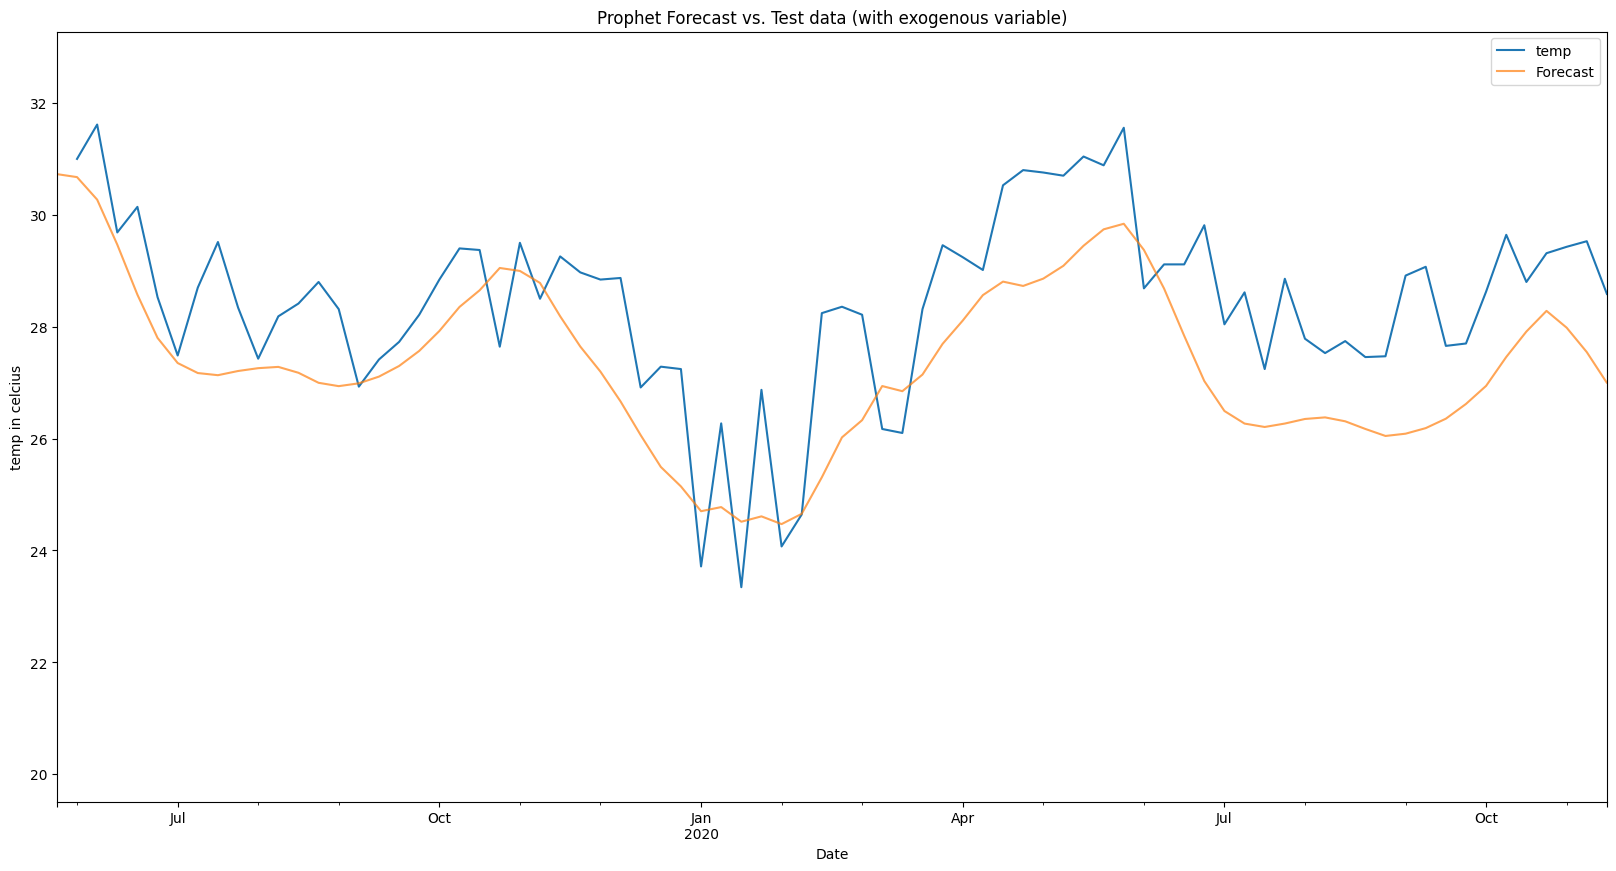

In [42]:
ax = test_target.plot(label='temp', figsize=(20, 10))
forecast_prophet_exog.plot(x='ds', y='yhat', ax=ax, label='Forecast', alpha=.7)
numerical_ds = pd.to_numeric(forecast_prophet_exog['ds']).values

ax.fill_between(numerical_ds,
                forecast_prophet_exog['yhat_lower'],
                forecast_prophet_exog['yhat_upper'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('temp in celcius')
ax.set_xlim('2019-05-26', '2020-11-15')
plt.title('Prophet Forecast vs. Test data (with exogenous variable)')
plt.legend()
plt.show()

In [43]:
filtered_forecast_exog = forecast_prophet_exog[
    (forecast_prophet_exog['ds'] > '2019-05-26') & (forecast_prophet_exog['ds'] <= '2020-11-15')
]

In [44]:
# calculate rmse
rmse_prophet_dew = np.sqrt(mean_squared_error(test_target, filtered_forecast_exog['yhat']))
print('Prophet - dew - Test RMSE: %.3f' % rmse_prophet_dew)

Prophet - dew - Test RMSE: 1.499


From the nature of the Exponential Smoothing model, it is not possible to implement the usage of an exougenous variable in its training.

We'll now compare the RMSE scores of each of the chosen trained models, discussion on the values is thoroughly shown on the Final Project Report.

In [45]:
print('SARIMA - Test RMSE: %.3f' % rmse_sarima)
print('SARIMA - dew - Test RMSE: %.3f' % rmse_sarima_dew)
print('Prophet - Test RMSE: %.3f' % rmse_prophet)
print('Prophet - dew - Test RMSE: %.3f' % rmse_prophet_dew)
print('Exponential Smoothing - Test RMSE: %.3f' % rmse_exs)

SARIMA - Test RMSE: 0.994
SARIMA - dew - Test RMSE: 0.989
Prophet - Test RMSE: 1.678
Prophet - dew - Test RMSE: 1.499
Exponential Smoothing - Test RMSE: 1.099


# Part 4 - Change-Point Detection

It does not look like there is a natural change-point in ou data

We'll use statistical tools for checking if there is a change in the distribution of the series over time.

Possible tools for doing so:



*   Shewart Control Chart
*   Sequental Tests of Hypothesis
*   **SPRT** - **S**equential **P**robability **R**atio **T**est
*   Wald's Lemma (applies on SPRT)
*   CUSUM - Cumulative Sum Surveillance Procedures





##Shewart Control Chart

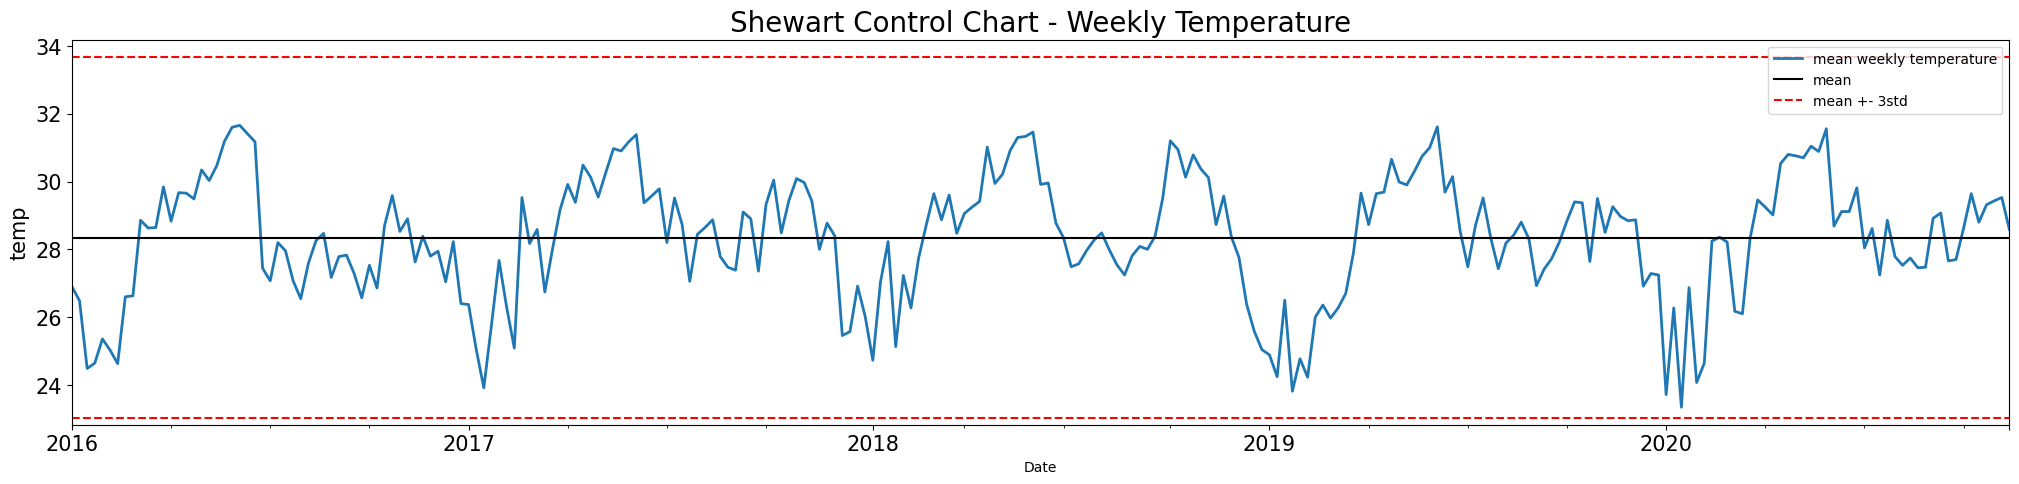

In [46]:
## firstly dhow the shewart control chart
std_temp_weekly = temp_weekly.std()
mean_temp_weekly = temp_weekly.mean()
three_std_temp_weekly = 3 * std_temp_weekly
temp_weekly.plot(figsize=(25, 5), linewidth=2, fontsize=15)
plt.title('Shewart Control Chart - Weekly Temperature', fontsize=20)
plt.xlabel('Date', fontsize=10)
plt.ylabel('temp', fontsize=15)
plt.axhline(y = mean_temp_weekly, color = 'black', linestyle = '-')
plt.axhline(y = mean_temp_weekly + three_std_temp_weekly, color = 'r', linestyle = '--')
plt.axhline(y = mean_temp_weekly - three_std_temp_weekly, color = 'r', linestyle = '--')
plt.legend(['mean weekly temperature', 'mean', 'mean +- 3std'], loc='upper right')
plt.show()

The point in time where we can see relevant change is in the beggining of 2020, and in the beggining of 2017 and 2019 a slight change even though we are within the control

##CUSUM

std: 1.7756027408851764
mean: 28.339327731092435
We have detected 24 change points
Detected change points (index, direction):
[(6, 'down'), (7, 'down'), (8, 'down'), (9, 'down'), (24, 'up'), (160, 'down'), (161, 'down'), (162, 'down'), (163, 'down'), (164, 'down'), (165, 'down'), (166, 'down'), (167, 'down'), (168, 'down'), (169, 'down'), (170, 'down'), (171, 'down'), (172, 'down'), (213, 'down'), (214, 'down'), (215, 'down'), (216, 'down'), (218, 'down'), (219, 'down')]


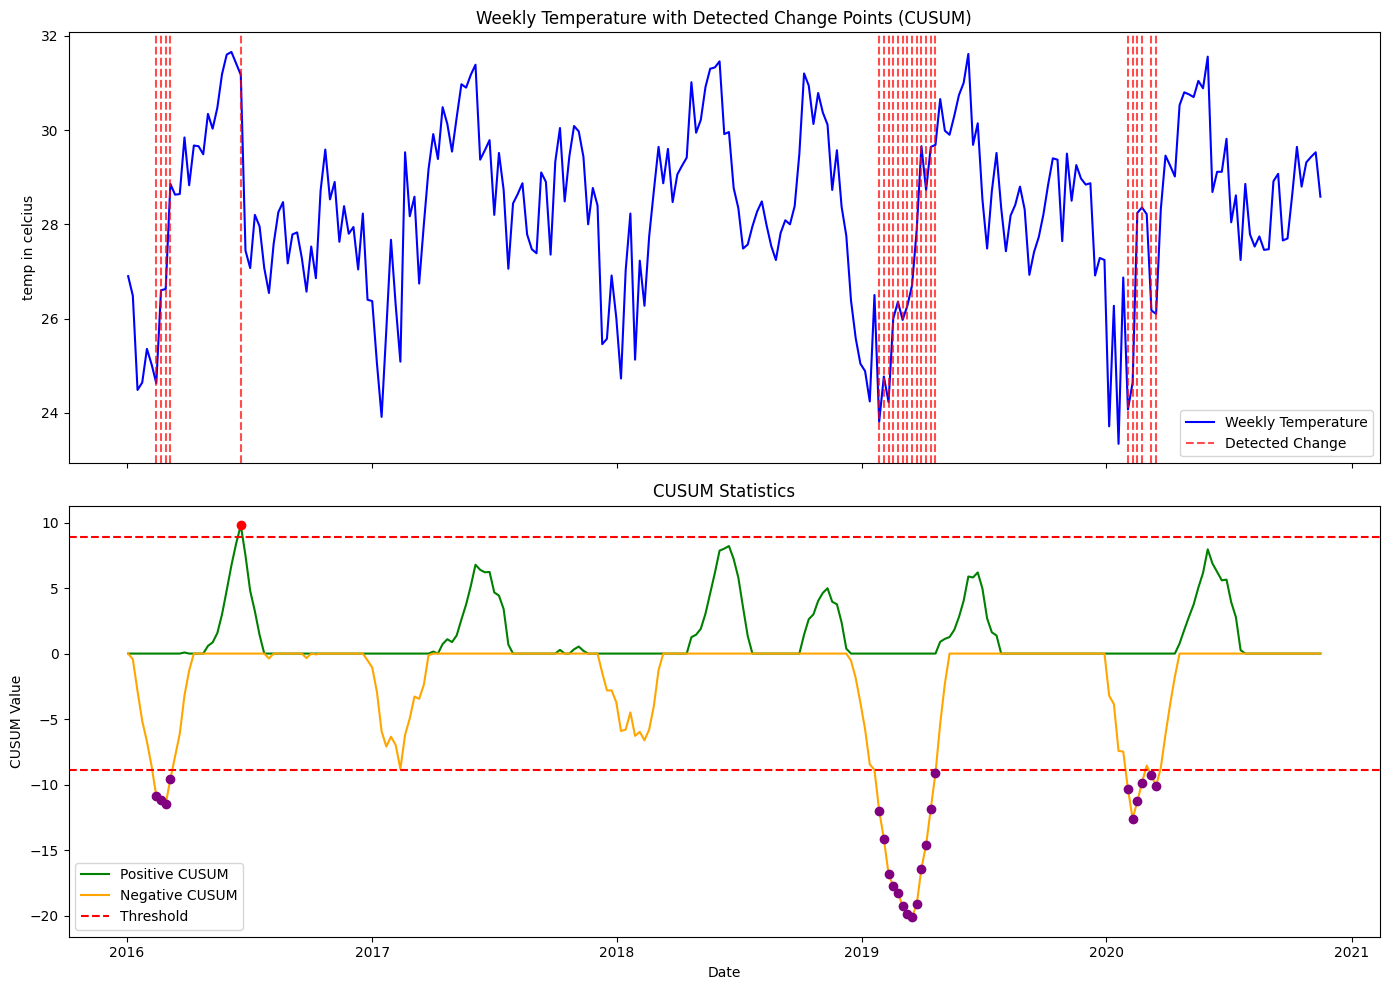

In [47]:
std_temp_weekly = temp_weekly.std()
target = temp_weekly.mean()
print(f'std: {std_temp_weekly}')
print(f'mean: {target}')

k = 0.8 * std_temp_weekly
h = 5 * std_temp_weekly

n = len(temp_weekly)
pos_cusum = np.zeros(n)
neg_cusum = np.zeros(n)
change_points = []

for i in range(1, n):
    pos_cusum[i] = max(0, pos_cusum[i-1] + temp_weekly.iloc[i] - target - k)
    neg_cusum[i] = min(0, neg_cusum[i-1] + temp_weekly.iloc[i] - target + k)

    if pos_cusum[i] > h:
        change_points.append((i, 'up'))
    if neg_cusum[i] < -h:
        change_points.append((i, 'down'))

print(f'We have detected {len(change_points)} change points')
print("Detected change points (index, direction):")
print(change_points)

fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].plot(temp_weekly.index, temp_weekly, label='Weekly Temperature', color='blue')
for idx, direction in change_points:
    ax[0].axvline(temp_weekly.index[idx], color='red', linestyle='--', alpha=0.7,
                  label='Detected Change' if idx == change_points[0][0] else "")

ax[0].set_title('Weekly Temperature with Detected Change Points (CUSUM)')
ax[0].set_ylabel('temp in celcius')
ax[0].legend()

ax[1].plot(temp_weekly.index, pos_cusum, label='Positive CUSUM', color='green')
ax[1].plot(temp_weekly.index, neg_cusum, label='Negative CUSUM', color='orange')
ax[1].axhline(h, color='red', linestyle='--', label='Threshold')
ax[1].axhline(-h, color='red', linestyle='--')
ax[1].set_title('CUSUM Statistics')
ax[1].set_ylabel('CUSUM Value')
ax[1].legend()

pos_change_points = [idx for idx, direction in change_points if direction == 'up']
neg_change_points = [idx for idx, direction in change_points if direction == 'down']

x_pos_change_points = [temp_weekly.index[idx] for idx, direction in change_points if direction == 'up']
x_neg_change_points = [temp_weekly.index[idx] for idx, direction in change_points if direction == 'down']
y_pos_change_points = [pos_cusum[idx] for idx, direction in change_points if direction == 'up']
y_neg_change_points = [neg_cusum[idx] for idx, direction in change_points if direction == 'down']

ax[1].scatter(x_pos_change_points, y_pos_change_points, color='red', label="Positive Change Points", zorder=5)
ax[1].scatter(x_neg_change_points, y_neg_change_points, color='purple', label="Negative Change Points", zorder=5)

plt.xlabel('Date')
plt.tight_layout()
plt.show()
